## Modules à importer

In [545]:
import re
import math
import glob
import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
import iminuit as im
import ipywidgets as ipw
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams['figure.facecolor'] = 'w'
from itertools import product as pt
import matplotlib as mpl
import pandas as pd
import random
import dask
import sys
sys.path.append('/home/Work/devpython/snana_parser/')

from snprop import age
from scipy import stats
from pymage import query
from astropy import units
from variaIa import tools as Iatools
from snprop import survey, tools
from matplotlib.colors import Normalize
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full
from mpl_toolkits.axes_grid1 import make_axes_locatable
from snana_parser import simulations, io, fitres, bbc
from astropy.cosmology import Planck15 as Planck15
from scipy.interpolate import interp2d as spline
from matplotlib.lines import Line2D
from snana_parser.utils import root
from dask.distributed import Client
# client = Client()
from pprint import PrettyPrinter
from variaIa import stretchevol as se
from variaIa import massevol
from importlib import reload

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [254]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=Iatools.cons, su=Iatools.su)
display(int_set_su)

smap = plt.cm.get_cmap('cividis')
#smap = plt.cm.get_cmap('viridis')
colors = {'SNF': plt.cm.binary(0.9),
          'LOWZ': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300),  # for viridis
          'All': (255/255, 51/255, 0/255)} 

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
df_nlowz = df_nc[df_nc['survey'] != 'low-z']
df_full_data = df_full[~df_full['survey'].isin(['SNF', 'HST'])]

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', optio…

## Basic plots

### Choose biascor

In [559]:
def set_choice(run):
    bc_dir = glob.glob(f'../../../Data/sims/NN_COMBINE_{run}/6_BIASCOR/*')
    bcs = [k.split('COR_')[-1] for k in bc_dir]
    bc.options = bcs
    if 'FULL' in run:
        oc.options = []
    if 'SIZE' in run:
        oc_dir = glob.glob(bc_dir[0] + '/output/OUT*')
        ocs = ['0000'] + [k.split('-')[-1] for k in oc_dir]
        ocs.sort(key=int)
        oc.options = ocs

def get_sim(run, bias, opt):
    global sim_path
    if 'FULL' in run:
        sim_path = f'../../../Data/sims/NN_COMBINE_{run}/6_BIASCOR/' +\
                   f'ALL_BIASCOR_{bias}/output/OUTPUT_BBCFIT/'
    if 'SIZE' in run:
        if opt == '0000':
            sim_path = f'../../../Data/sims/NN_COMBINE_{run}/6_BIASCOR/' +\
                       f'ALL_BIASCOR_{bias}/output/OUTPUT_BBCFIT/'
        else:
            sim_path = f'../../../Data/sims/NN_COMBINE_{run}/6_BIASCOR/' +\
                       f'ALL_BIASCOR_{bias}/output/OUTPUT_BBCFIT-{opt}/'

opt_dir = glob.glob('../../../Data/sims/NN_COMBINE_*')
opts = [''] + [k.split('_')[-1] for k in opt_dir]
rc = ipw.Dropdown(options=opts, description='Run choice')
bc = ipw.Dropdown(description='Bias choice')
oc = ipw.Dropdown(description='Out choice')

def dropdown_eventhandler(change):
    set_choice(rc.value)

rc.observe(dropdown_eventhandler, names='value')
sp = ipw.interactive(get_sim, run=rc, bias=bc, opt=oc)
display(ipw.HBox([rc, bc, oc]))

In [135]:
tools.Checker.from_biascor(sim_path, df_full_data, cols=None).modif

,ROW,zMIN,zMAX,z,MUDIF,MUDIFERR,MUREF,NFIT
0,1,0.01500,0.04449,0.02961,0.0103,0.0143,35.5648,130
1,2,0.04449,0.07672,0.05313,0.0121,0.0267,36.8714,23
2,3,0.07672,0.11212,0.09425,0.0012,0.0204,38.1782,33
3,4,0.11212,0.15126,0.13358,0.0223,0.0147,38.9916,69
4,5,0.15126,0.19485,0.17187,0.0370,0.0142,39.5907,82
5,6,0.19485,0.24380,0.21864,-0.0109,0.0158,40.1731,77
6,7,0.24380,0.29930,0.26953,0.0234,0.0130,40.6883,112
7,8,0.29930,0.36296,0.32599,-0.0196,0.0160,41.1642,70
8,9,0.36296,0.43701,0.39094,-0.0142,0.0201,41.6257,47
9,10,0.43701,0.52459,0.48056,-0.0302,0.0234,42.1580,36


#### Choose SIM

In [253]:
checkit.wall

,ROW,VERSION,FITOPT,MUOPT,w,wsig,omm,omm_sig,chi2,sigint
0,1,OUTPUT_BBCFIT,0,0,-1.0314,0.0194,0.3160,0.0057,22.5,0.0
1,2,OUTPUT_BBCFIT,0,1,-1.0461,0.0157,0.3136,0.0040,13.6,0.0
2,3,OUTPUT_BBCFIT,0,2,-1.0273,0.0195,0.3157,0.0056,28.1,0.0
3,4,OUTPUT_BBCFIT,0,3,-1.0231,0.0194,0.3166,0.0059,24.3,0.0
4,5,OUTPUT_BBCFIT,0,4,-1.0192,0.0188,0.3161,0.0057,22.6,0.0


In [183]:
sims_path = glob.glob(sim_path[:-1] + '-*/FITOPT' + '000' + '_' + 'MUOPT' + '000' + '.FITRES')
sims_data = [tools.Checker.read(f) for f in sims_path]
sims_numbers = [f.split('-')[-1].split('/')[0] for f in sims_path]
sims_data = pd.concat(sims_data, keys=sims_numbers)
#sims_data = pd.concat(sims_data, keys='SIM')

In [188]:
modif_path = glob.glob(sim_path[:-1] + '-*/FITOPT' + '000' + '_' + 'MUOPT' + '000' + '.M0DIF')
sims_numbers = [f.split('-')[-1].split('/')[0] for f in modif_path]
modif = pd.concat([tools.Checker.read(f) for f in modif_path], keys=sims_numbers)
modif

ROW     zMIN     zMAX        z   MUDIF  MUDIFERR    MUREF  NFIT
0097 0     1  0.01500  0.04449  0.02907 -0.0036    0.0164  35.5240   107
     1     2  0.04449  0.07672  0.05816 -0.0178    0.0218  37.0756    36
     2     3  0.07672  0.11212  0.09554 -0.0173    0.0215  38.2094    30
     3     4  0.11212  0.15126  0.13028 -0.0156    0.0169  38.9327    54
     4     5  0.15126  0.19485  0.17207  0.0082    0.0140  39.5935    85
...      ...      ...      ...      ...     ...       ...      ...   ...
0450 10   11  0.52459  0.63044  0.58249 -0.0409    0.0272  42.6611    26
     11   12  0.63044  0.76191  0.68582  0.0026    0.0314  43.0926    35
     12   13  0.76191  0.93135  0.82282 -0.0332    0.0337  43.5778    32
     13   14  0.93135  1.16147  0.95996 -0.0836    0.0770  43.9906     6
     14   15  1.16147  1.50000  1.22629  0.0000  999.0000   0.0000     0

[7500 rows x 8 columns]

In [242]:
temp = modif.loc['0001'].copy()
temp['z'] = modif.groupby(level=1)['z'].mean()
temp['MUDIF'] = modif.groupby(level=1)['MUDIF'].mean()
temp['MUDIFERR'] = modif.groupby(level=1)['MUDIF'].std()/len(modif.index.levels[0])
temp['NFIT'] = modif.groupby(level=1)['NFIT'].sum()

In [243]:
temp

,ROW,zMIN,zMAX,z,MUDIF,MUDIFERR,MUREF,NFIT
0,1,0.01500,0.04449,0.028516,0.001474,0.000025,35.4102,56162
1,2,0.04449,0.07672,0.056421,-0.000142,0.000042,37.0148,18167
2,3,0.07672,0.11212,0.096216,0.004816,0.000041,38.2116,15875
3,4,0.11212,0.15126,0.132028,0.003349,0.000029,38.9637,31885
4,5,0.15126,0.19485,0.172262,0.003723,0.000027,39.6278,39498
5,6,0.19485,0.24380,0.218302,0.005550,0.000028,40.1449,42308
6,7,0.24380,0.29930,0.270272,0.005980,0.000029,40.7094,41619
7,8,0.29930,0.36296,0.327767,-0.000893,0.000031,41.1361,32918
8,9,0.36296,0.43701,0.396361,-0.009923,0.000040,41.6590,23537
9,10,0.43701,0.52459,0.476083,-0.007752,0.000054,42.1153,16219


In [244]:
modif.append(temp.assign(k='0000').set_index('k',append=True).swaplevel(0,1))

ROW     zMIN     zMAX         z     MUDIF  MUDIFERR    MUREF   NFIT
0097 0     1  0.01500  0.04449  0.029070 -0.003600  0.016400  35.5240    107
     1     2  0.04449  0.07672  0.058160 -0.017800  0.021800  37.0756     36
     2     3  0.07672  0.11212  0.095540 -0.017300  0.021500  38.2094     30
     3     4  0.11212  0.15126  0.130280 -0.015600  0.016900  38.9327     54
     4     5  0.15126  0.19485  0.172070  0.008200  0.014000  39.5935     85
...      ...      ...      ...       ...       ...       ...      ...    ...
0000 10   11  0.52459  0.63044  0.576057 -0.004837  0.000061  42.6292  13698
     11   12  0.63044  0.76191  0.695207 -0.012475  0.000059  43.1082  17091
     12   13  0.76191  0.93135  0.830357 -0.012582  0.000065  43.5934  16769
     13   14  0.93135  1.16147  0.970815 -0.002813  0.000193  43.9987   3373
     14   15  1.16147  1.50000  1.226290  0.000000  0.000000   0.0000      0

[7515 rows x 8 columns]

In [245]:
modif

ROW     zMIN     zMAX        z   MUDIF  MUDIFERR    MUREF  NFIT
0097 0     1  0.01500  0.04449  0.02907 -0.0036    0.0164  35.5240   107
     1     2  0.04449  0.07672  0.05816 -0.0178    0.0218  37.0756    36
     2     3  0.07672  0.11212  0.09554 -0.0173    0.0215  38.2094    30
     3     4  0.11212  0.15126  0.13028 -0.0156    0.0169  38.9327    54
     4     5  0.15126  0.19485  0.17207  0.0082    0.0140  39.5935    85
...      ...      ...      ...      ...     ...       ...      ...   ...
0450 10   11  0.52459  0.63044  0.58249 -0.0409    0.0272  42.6611    26
     11   12  0.63044  0.76191  0.68582  0.0026    0.0314  43.0926    35
     12   13  0.76191  0.93135  0.82282 -0.0332    0.0337  43.5778    32
     13   14  0.93135  1.16147  0.95996 -0.0836    0.0770  43.9906     6
     14   15  1.16147  1.50000  1.22629  0.0000  999.0000   0.0000     0

[7500 rows x 8 columns]

In [14]:
sims_path = glob.glob(sim_path[:-1] + '-*/FITOPT' + '000' + '_' + 'MUOPT' + '000' + '.FITRES')
fitres = pd.concat([tools.Checker.read(k) for k in sims_path])
fitres_data = tools.Checker.sample_sims(fitres, df_full_data)
checkit = tools.Checker.from_input(fitres, df_full_data)

### Sample sims to data

#### Just to check

In [12]:
surveys_size = {survey: len(df_full[df_full['survey'] == survey])
                for survey in surveys[1:-1]}

fitres_size = {survey: len(fitres[fitres['IDSURVEY'].isin(idsurvey)])
                 for survey, idsurvey in zip(surveys[1:-1],
                                             [[5, 64, 65, 66], [1], [15], [4]])}

fitres_data_size = {survey: len(fitres_data[fitres_data['IDSURVEY'].isin(idsurvey)])
                     for survey, idsurvey in zip(surveys[1:-1],
                                             [[5, 64, 65, 66], [1], [15], [4]])}

In [13]:
print('surveys_size =\t\t', surveys_size)
print('fitres_size =\t\t', fitres_size)
print('fitres_data_size =\t', fitres_data_size)

print('low-z ratio in data =', surveys_size['LOWZ']/surveys_size['LOWZ'])
print(' SDSS ratio in data =', surveys_size['SDSS']/surveys_size['LOWZ'])
print('  PS1 ratio in data =', surveys_size['PS1']/surveys_size['LOWZ'])
print(' SNLS ratio in data =', surveys_size['SNLS']/surveys_size['LOWZ'])

print('low-z ratio in uncut sims =', fitres_size['LOWZ']/fitres_size['LOWZ'])
print(' SDSS ratio in uncut sims =', fitres_size['SDSS']/fitres_size['LOWZ'])
print('  PS1 ratio in uncut sims =', fitres_size['PS1']/fitres_size['LOWZ'])
print(' SNLS ratio in uncut sims =', fitres_size['SNLS']/fitres_size['LOWZ'])

print('low-z ratio in cut sims =', fitres_data_size['LOWZ']/fitres_data_size['LOWZ'])
print(' SDSS ratio in cut sims =', fitres_data_size['SDSS']/fitres_data_size['LOWZ'])
print('  PS1 ratio in cut sims =', fitres_data_size['PS1']/fitres_data_size['LOWZ'])
print(' SNLS ratio in cut sims =', fitres_data_size['SNLS']/fitres_data_size['LOWZ'])

surveys_size =		 {'LOWZ': 172, 'SDSS': 335, 'PS1': 279, 'SNLS': 236}
fitres_size =		 {'LOWZ': 191504, 'SDSS': 360608, 'PS1': 329604, 'SNLS': 329468}
fitres_data_size =	 {'LOWZ': 185147, 'SDSS': 360606, 'PS1': 300325, 'SNLS': 254038}
low-z ratio in data = 1.0
 SDSS ratio in data = 1.947674418604651
  PS1 ratio in data = 1.622093023255814
 SNLS ratio in data = 1.372093023255814
low-z ratio in uncut sims = 1.0
 SDSS ratio in uncut sims = 1.8830311638399198
  PS1 ratio in uncut sims = 1.7211337622190659
 SNLS ratio in uncut sims = 1.7204235942852368
low-z ratio in cut sims = 1.0
 SDSS ratio in cut sims = 1.9476740103809405
  PS1 ratio in cut sims = 1.622089474849714
 SNLS ratio in cut sims = 1.3720881245712866


### Now plot!

In [263]:
checkit = tools.Checker.from_biascor(sim_path,
                                     df_full_data)

Text(0.5, 1.0, 'FULL-7DSK')

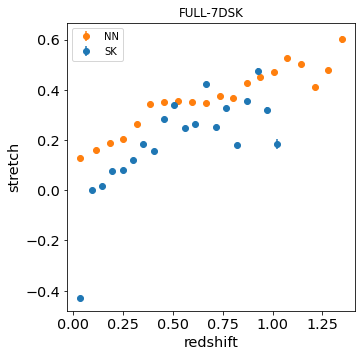

In [27]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_axes([0.1, 0.2, 0.8, 0.8])

checkit_SK = tools.Checker.from_biascor('../../../Data/sims/NN_COMBINE_FULL-7D/6_BIASCOR/ALL_BIASCOR_SK_NR/output/OUTPUT_BBCFIT/',
                                     df_full_data)

toplot = checkit.sims_data.copy()
toplot['zBIN'] = pd.cut(toplot.zCMB, 20)
toplotg = toplot.groupby('zBIN').mean()
toplotg['x1ERR'] = toplot.groupby('zBIN')['x1'].std() /\
    toplot.groupby('zBIN')['x1'].size()

toplot_SK = checkit_SK.sims_data.copy()
toplot_SK['zBIN'] = pd.cut(toplot_SK.zCMB, 20)
toplot_SKg = toplot_SK.groupby('zBIN').mean()
toplot_SKg['x1ERR'] = toplot_SK.groupby('zBIN')['x1'].std() /\
    toplot_SK.groupby('zBIN')['x1'].size()

ax.errorbar(toplotg['zCMB'], toplotg['x1'],
            yerr=toplotg['x1ERR'], fmt='o', color='C1',
           label='NN')
ax.errorbar(toplot_SKg['zCMB'], toplot_SKg['x1'],
            yerr=toplot_SKg['x1ERR'], fmt='o', color='C0',
           label='SK')

ax.tick_params(labelsize='x-large')
ax.set_xlabel('redshift', fontsize='x-large')
ax.set_ylabel('stretch', fontsize='x-large')

ax.legend()

ax.set_title(rc.value + bc.value.split('_')[0])

In [4]:
order = ['SK', 'BP', 'NN', 'NR']
inputs = {xx: {kind: pd.concat([tools.Checker.read(glob.glob('/'.join(sim_path.split('/')[:6]) +
                                            f'/5_MERGE/MERGE_{survey}{kind[0]}_{survey}_{kind}-{xx}/' +
                                            'output/PIP*/FITOPT000.FITRES')[0])
                                for survey in surveys[1:-1]])
                           for kind in ['DATA', 'SIM']}
             for xx in order}

In [8]:
pickle.dump(inputs, open('/'.join(sim_path.split('/')[:6])+'/5_MERGE/inputs', 'wb'))

In [4]:
with open('/'.join(sim_path.split('/')[:6])+'/5_MERGE/inputs', 'rb') as f:
    inputs = pickle.load(f)

In [40]:
checkit = tools.Checker.from_input(inputs['NR']['SIM'], inputs['NN']['DATA'],
                                   between_fitres=True, name=rc.value + '_NN_NR',
                                   cols=inputs['NR']['SIM'].columns)

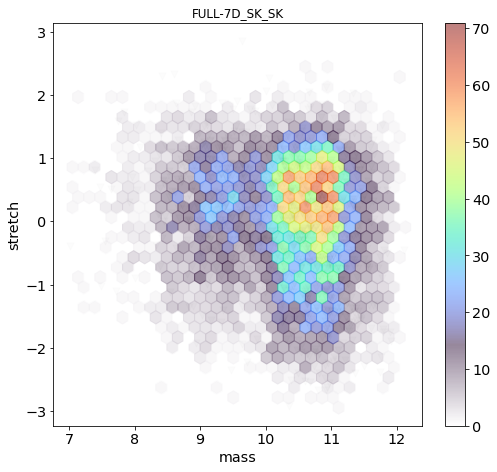

In [261]:
fig = plt.figure(figsize=[8,7])
ax = fig.add_axes([0.1, 0.2, 0.8, 0.8])

checkit.show_scatter('mass', 'stretch',
                     survey='all',
                     #between_fitres=True,
                     ax=ax, fc_data='k',
                     alpha_data=0.01, mk_data='v')

ax.set_title(checkit.name)

fig.savefig(f'../../../Images/pdf/{checkit.name}_MS_scatter.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/{checkit.name}_MS_scatter.png', bbox_inches='tight', dpi=600)

In [572]:
find_id = tools.Checker.find_id

for kind in order:
    fig, axs = plt.subplots(4, 5, figsize=[32, 28])
                            #sharex=True, sharey=True)
    for i, surv in enumerate(surveys[1:-1]):
        plt.rcParams['xtick.labelsize'] = 'x-large'
        plt.rcParams['ytick.labelsize'] = 'x-large'
        plt.rcParams['axes.labelsize'] = 'x-large'
    
        checkf = checkthem['FULL-7D'][f'{kind}'][f'{kind}']['002'].sims_data
        checkf = checkf[checkf['IDSURVEY'].isin(find_id[surv])]
        checkfm = checkthem['FULL-7DMAJSHIFT'][f'{kind}'][f'{kind}']['002'].sims_data
        checkfm = checkfm[checkfm['IDSURVEY'].isin(find_id[surv])]
        
        ##############################################################################
        
        ha = axs[i][0].hist(checkf['x1'].values, bins=10,
                            histtype='step', lw=2,
                            density=True, orientation='horizontal',
                            color='C0', alpha=.2, label='FULL')
        
        hb = axs[i][0].hist(checkfm['x1'].values, bins=ha[1],
                            density=True, orientation='horizontal',
                            color='C1', alpha=.2, label='FULL-MAJSHIFT')
        
        mid = (ha[1][:-1]+ha[1][1:])/2
        hdiff = ha[0]-hb[0]
        wid = ha[1][1] - ha[1][0]
        
        hbc = axs[i][0].barh(mid, hdiff, wid, #align='edge',
                            color='C2', alpha=.2, label='Diff')
        axs[i][0].set_xlim([-0.15, 0.7])
        
        axs[i][0].axvline(0, c='k', lw=1, ls='--')
        axs[i][0].invert_xaxis()
        
        axs[i][0].set_ylabel(r'$x_1$', fontsize=25)
        axs[i][0].tick_params(labelsize=20)
        axs[i][0].set_ylim([-3, 3])
        axs[i][0].legend(loc='upper left', fontsize=20)
        
        axs[i][0].text(0.68, 0, surv,
                       va='center', ha='left',
                       rotation=90, fontsize=26)
        
        ##############################################################################
        
        hba = axs[i][1].hexbin(checkf['HOST_LOGMASS'].values,
                            checkf['x1'].values,
                            gridsize=30, extent=(7.8, 12.2, -3, 3),
                            cmap=tools.cmap_tpw)#, vmin=0, vmax=60)
        # divider = make_axes_locatable(axs[i][0])
        # cax = divider.append_axes('right', size='5%', pad=0.05)
        # axs[i][0].figure.colorbar(hba, cax=cax)
        axs[i][1].set_yticks([])
        
        hbb = axs[i][2].hexbin(checkfm['HOST_LOGMASS'].values,
                            checkfm['x1'].values,
                            gridsize=30, extent=(7.8, 12.2, -3, 3),
                            cmap=tools.cmap_tpw,
                            vmin=np.min(hba.get_array()),
                            vmax=np.max(hba.get_array()))
        # divider = make_axes_locatable(axs[i][1])
        # cax = divider.append_axes('right', size='5%', pad=0.05)
        # axs[i][1].figure.colorbar(hbb, cax=cax)
        axs[i][2].set_yticks([])
        
        hdiff = 2*(hba.get_array()-hbb.get_array())/(hba.get_array()+hbb.get_array())
        hmax = np.max(np.abs(hdiff))
        hbc = axs[i][3].hexbin(checkfm['HOST_LOGMASS'].values,
                             checkfm['x1'].values,
                             vmin=-hmax,
                             vmax=hmax,
                             gridsize=30, extent=(7.8, 12.2, -3, 3),
                             cmap='seismic')
        hbc.set_array(hdiff)
        
        divider = make_axes_locatable(axs[i][3])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        axs[i][3].figure.colorbar(hbc, cax=cax, ticks=np.linspace(-1.7, 1.7, 9))
        cax.yaxis.set_ticks_position('left')
        cax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
        cax.tick_params(rotation=45)
        axs[i][3].set_yticks([])
        
        ##############################################################################
        
        ha = axs[i][4].hist(checkf['HOST_LOGMASS'].values, bins=10,
                            histtype='step', lw=2, density=True,
                            color='C0', alpha=.2, label='FULL')
        
        hb = axs[i][4].hist(checkfm['HOST_LOGMASS'].values, bins=ha[1],
                            density=True,
                            color='C1', alpha=.2, label='FULL-MAJSHIFT')
        
        mid = (ha[1][:-1]+ha[1][1:])/2
        hdiff = ha[0]-hb[0]
        wid = ha[1][1] - ha[1][0]
        hbc = axs[i][4].bar(mid, hdiff, width=wid, #align='edge',
                            color='C2', alpha=.2, label='Diff')
        
        axs[i][4].axhline(0, c='k', lw=1, ls='-.')
        
        axs[i][4].set_xlim([7.8, 12.2])
        axs[i][4].set_yticks([])
        
        axs[i][4].legend(loc='upper left', fontsize=20)
        
        ##############################################################################
        
        if i < 3:
            for k in range(5):
                axs[i][k].set_xticks([])
        
        if i == 3:
            for k in range(1,5):
                axs[i][k].set_xlabel(r'$M_{\rm host}$', fontsize=25)
            for k in range(5):
                axs[i][k].tick_params(labelsize=20)
        if i == 0:
            axs[i][1].text(10.0, 3.2, 'FULL-7D',
                           va='top', ha='center',
                           fontsize=24)
            axs[i][2].text(10.0, 3.2, 'FULL-7DMAJSHIFT',
                           va='top', ha='center',
                           fontsize=24)
            axs[i][3].text(10.0, 3.2, 'Diff',
                           va='top', ha='center',
                           fontsize=24)
        
    fig.tight_layout(w_pad=-0.3, h_pad=-1.8)
    fig.suptitle(f'{kind}', y=1.01, fontsize=20)
    plt.close()
    fig.savefig(f'../../../Images/pdf/FULL-7Dv7DMAJSHIFT_{kind}.pdf', bbox_inches='tight')
    fig.savefig(f'../../../Images/png/FULL-7Dv7DMAJSHIFT_{kind}.png', bbox_inches='tight')

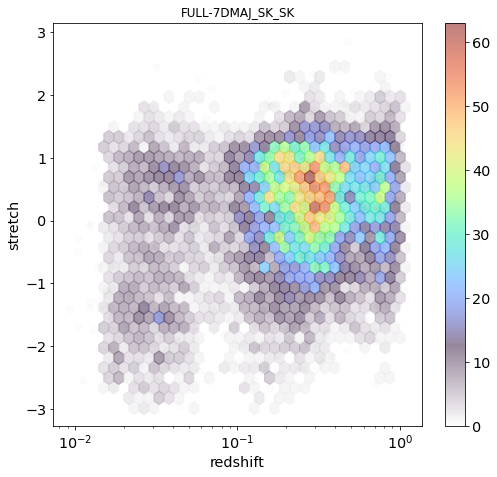

In [264]:
fig = plt.figure(figsize=[8,7])
ax = fig.add_axes([0.1, 0.2, 0.8, 0.8])

checkit.show_scatter('redshift', 'stretch',
                     ax=ax, fc_data='k',
                     alpha_data=0.01, xsimscale='log')
ax.set_title(checkit.name)

fig.savefig(f'../../../Images/pdf/{checkit.name}_RS_scatter.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/{checkit.name}_RS_scatter.png', bbox_inches='tight', dpi=600)

In [5]:
checkit.set_kernel('mass', 'stretch', True)
checkit.set_kernel('redshift', 'stretch', True)

In [12]:
pickle.dump(checkit.kernels, open('/'.join(sim_path.split('/')[:6])+'/checkit_NN_NR-kernels', 'wb'))

In [13]:
with open('/'.join(sim_path.split('/')[:6])+'/checkit_NN_NR-kernels', 'rb') as f:
    checkit_kernels = pickle.load(f)

<Axes:xlabel='redshift', ylabel='stretch'>

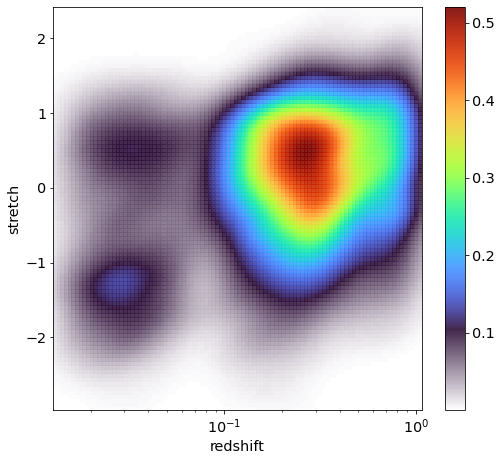

In [17]:
fig = plt.figure(figsize=[8, 7])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

#ax = checkit.show_kernel(kernel=kernel,
#                         abs_name='redshift', ord_name='stretch',
#                         aspect=.8, alpha_kernel=.50)

checkit.show_kernel('redshift_stretch', ax=ax,
                    xscale='log',
                    alpha_kernel=.90)
                    #aspect=.4, alpha_kernel=.90)

#ax.set_xscale('log')

# checkit.show_scatter('redshift', 'stretch', ax=ax,
#                      gsize=40,
#                      xsimscale='log', #cmap='inferno',
#                      alpha_sims=0.1, show_cb=False, alpha_data=0.0)

In [17]:
checkit.fit('mass_stretch', between_fitres=True)
#checkit.fit('redshift_stretch')

2016.3440997151708

In [18]:
checkit.fits

{'mass_stretch': 2016.3440997151708}

In [125]:
pickle.dump(checkit, open(sc.value + '/checkit', 'wb'))

In [134]:
with open(sc.value + '/checkit', 'rb') as f:
    checkit = pickle.load(f)

In [135]:
checkit.wfit

,w,wsig_marg,OM,OMsig_marg,chi2,Ndof,sigint,wran,OMran,label,ABORT_IF_ZERO,CPU_MINUTES,BLIND
1,-1.0105,0.0548,0.3106,0.0100,13.6,8,0.012,0,0,none,8 # same as Ndof,0.02,0


Text(0.5, 1.0, '7D')

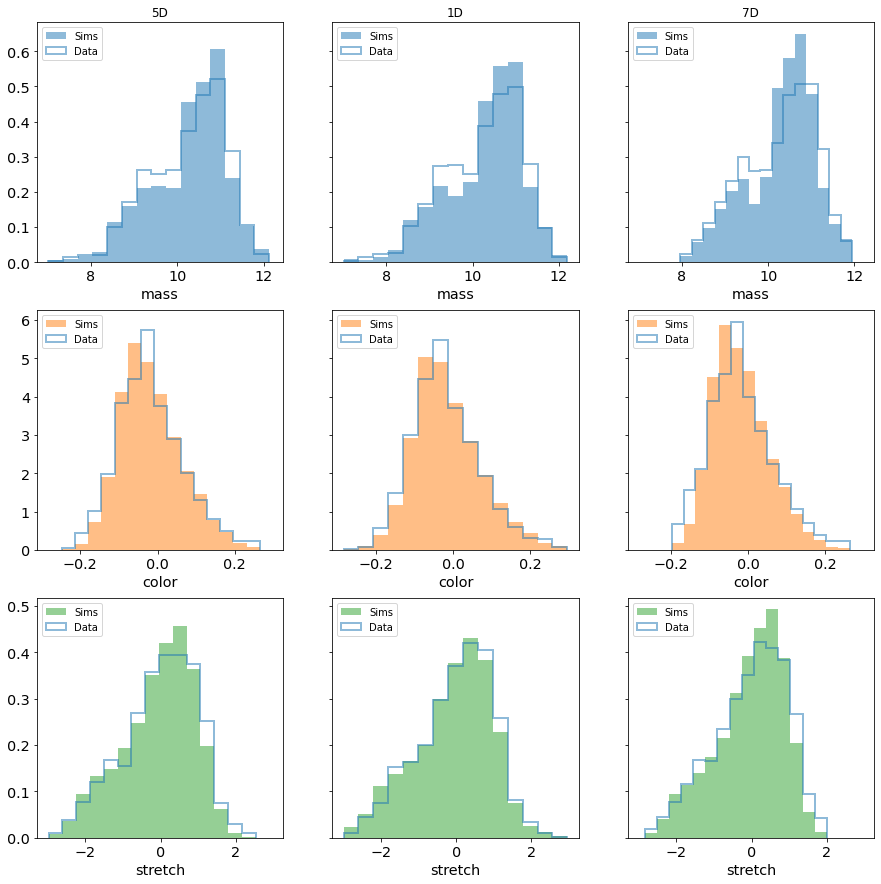

In [139]:
fig, axs = plt.subplots(3, 3, figsize=[15, 15], sharex='row', sharey='row')
for i in range(3):
    checkthem[rc.value]['BP']['BP']['00'+str(i)].show_hist('mass', ax=axs[0][i],
                                                           fc_sims='C0', show_leg=True)
    checkthem[rc.value]['BP']['BP']['00'+str(i)].show_hist('color', ax=axs[1][i],
                                                           fc_sims='C1', show_leg=True)
    checkthem[rc.value]['BP']['BP']['00'+str(i)].show_hist('stretch', ax=axs[2][i],
                                                           fc_sims='C2', show_leg=True)
axs[0][0].set_title('5D')
axs[0][1].set_title('1D')
axs[0][2].set_title('7D')

## Plot $w$, $\gamma$ values

In [357]:
MUO = ipw.Dropdown(options=[0, 1, 2, 3, 4, 5],
                   description='MUOPTS',
                   value=0)
par = ipw.Dropdown(options=['alpha', 'beta', 'gamma', 'w'],
                   description='Param',
                   value='w')
display(ipw.HBox([MUO, par]))

In [556]:
order = ['SK', 'BP', 'NN', 'NR']
opt_dir = glob.glob('../../../Data/sims/NN_COMBINE_*FULL*')
runs = [k.split('_')[-1] for k in opt_dir]
nums = {run: tools.Checker.get_numbers(f'../../../Data/sims/NN_COMBINE_{run}/6_BIASCOR/' +
                                       f'ALL_BIASCOR_BP_BP/output/OUTPUT_BBCFIT/')
       for run in runs}
checkthem = {run: {z: {s: {num.T[-1]: tools.Checker.from_biascor(
                                   f'../../../Data/sims/NN_COMBINE_{run}/6_BIASCOR/' +
                                   f'ALL_BIASCOR_{z}_{s}/output/OUTPUT_BBCFIT/',
                                   df_full_data, cols=None,
                                   folnum=num)
                                for num in nums[run]}
                            for s in order}
                   for z in order}
             for run in runs}

In [251]:
for run in runs:
    for z in order:
        for s in order:
            for num in ['000', '001', '002']:
                checkthem[run][z][s][num].set_kernel('mass', 'stretch', True)
                checkthem[run][z][s][num].set_kernel('redshift', 'stretch', True)
                checkthem[run][z][s][num].fit('mass_stretch')
                checkthem[run][z][s][num].fit('redshift_stretch')
kde_fits = {run: {z: {s: {num: checkthem[run][z][s][num].fits
                          for num in nums[run].T[-1][:3]}
                      for s in order}
                  for z in order}
             for run in runs}

In [252]:
kde_fits

{'FULL-1D': {'SK': {'SK': {'000': {'mass_stretch': 101.46035241062874,
     'redshift_stretch': 12.662828142302931},
    '001': {'mass_stretch': 101.46035241062874,
     'redshift_stretch': 12.662828142302931},
    '002': {'mass_stretch': 101.46035241062874,
     'redshift_stretch': 12.662828142302931}},
   'BP': {'000': {'mass_stretch': 101.46035241062874,
     'redshift_stretch': 12.662828142302931},
    '001': {'mass_stretch': 101.46035241062874,
     'redshift_stretch': 12.662828142302931},
    '002': {'mass_stretch': 101.46035241062874,
     'redshift_stretch': 12.662828142302931}},
   'NN': {'000': {'mass_stretch': 101.46035241062874,
     'redshift_stretch': 12.662828142302931},
    '001': {'mass_stretch': 101.46035241062874,
     'redshift_stretch': 12.662828142302931},
    '002': {'mass_stretch': 101.46035241062874,
     'redshift_stretch': 12.662828142302931}},
   'NR': {'000': {'mass_stretch': 101.46035241062874,
     'redshift_stretch': 12.662828142302931},
    '001': {'mas

In [557]:
para_vals = {run: {z: {s: {num: {p:
                                  float(checkthem[run][z][s][num].wfit[p].values[0])
                                  if p == 'w' else
                                  checkthem[run][z][s][num].gab[p].values[0]
                                  for p in par.options}
                          for num in nums[run].T[-1][:3]}
                      for s in order}
                  for z in order}
             for run in runs}
para_errs = {run: {z: {s: {num: {p:
                                  float(checkthem[run][z][s][num].wfit[p + '_err'].values[0])
                                  if p == 'w' else
                                  checkthem[run][z][s][num].gab[p + '_err'].values[0]
                                  for p in par.options}
                          for num in nums[run].T[-1][:3]}
                      for s in order}
                  for z in order}
             for run in runs}

In [558]:
show_vals = {run: {num: {p: {z: {s:
                                  float(checkthem[run][z][s][num].wfit[p].values[0])
                                  if p == 'w' else
                                  checkthem[run][z][s][num].gab[p].values[0]
                                  for s in order}
                          for z in order}
                      for p in par.options}
                  for num in nums[run].T[-1][:3]}
             for run in runs}
show_errs = {run: {num: {p: {z: {s:
                                  float(checkthem[run][z][s][num].wfit[p + '_err'].values[0])
                                  if p == 'w' else
                                  checkthem[run][z][s][num].gab[p + '_err'].values[0]
                                  for s in order}
                          for z in order}
                      for p in par.options}
                  for num in nums[run].T[-1][:3]}
             for run in runs}

In [356]:
pickle.dump(checkthem, open('../../../Data/sims/checkthem', 'wb'))
pickle.dump(para_vals, open('../../../Data/sims/para_vals', 'wb'))
pickle.dump(para_errs, open('../../../Data/sims/para_errs', 'wb'))
pickle.dump(show_vals, open('../../../Data/sims/show_vals', 'wb'))
pickle.dump(show_errs, open('../../../Data/sims/show_errs', 'wb'))

In [22]:
order = ['SK', 'BP', 'NN', 'NR']
with open('../../../Data/sims/checkthem', 'rb') as f:
    checkthem = pickle.load(f)
with open('../../../Data/sims/para_vals', 'rb') as f:
    para_vals = pickle.load(f)
with open('../../../Data/sims/para_errs', 'rb') as f:
    para_errs = pickle.load(f)
with open('../../../Data/sims/show_vals', 'rb') as f:
    show_vals = pickle.load(f)
with open('../../../Data/sims/show_errs', 'rb') as f:
    show_errs = pickle.load(f)

### $\gamma$

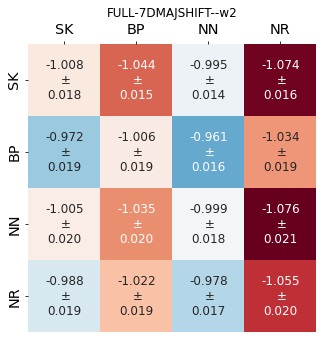

In [560]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

cbarlb = {'label': r'$w$ values',
          'fraction':0.05}#,
          #'labelsize': 'x-large'} #'aspect':50,
    
akws = {'fontsize': 'large'}

muo = '00'+str(MUO.value)
labels = [[f'{show_vals[rc.value][muo][par.value][k][i]:.3f}\n ±\n' +
           f'{show_errs[rc.value][muo][par.value][k][i]:.3f}'
           for k in order]
          for i in order]
center = {'w': -1, 'gamma': 0.05, 'alpha': 0.145, 'beta': 3.1}
cmap = mpl.cm.get_cmap('RdBu')

sn.heatmap(pd.DataFrame(show_vals[rc.value]['00'+str(MUO.value)][par.value]),
           ax=ax,
           annot=labels, annot_kws=akws, fmt='',
           cmap=cmap, center=center[par.value],
           # vmin=-5, vmax=5,
           cbar=False, #cbar_kws=cbarlb,
           xticklabels=order,
           yticklabels=order)

imc = ax.collections[0]
rgba_values = imc.cmap(imc.norm(imc.get_array()))
def bg_vals(alpha):
    rgba_copy = rgba_values.copy()
    rgba_copy[:, -1] = alpha
    return rgba_copy

ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')

ax.tick_params(labelsize='x-large')

ax.set_title(rc.value + '--' + par.value + str(MUO.value))

fig.savefig(f'../../../Images/pdf/{par.value}fit_covmat_{rc.value}_{MUO.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/{par.value}fit_covmat_{rc.value}_{MUO.value}.png', bbox_inches='tight', dpi=600)

### HR plots

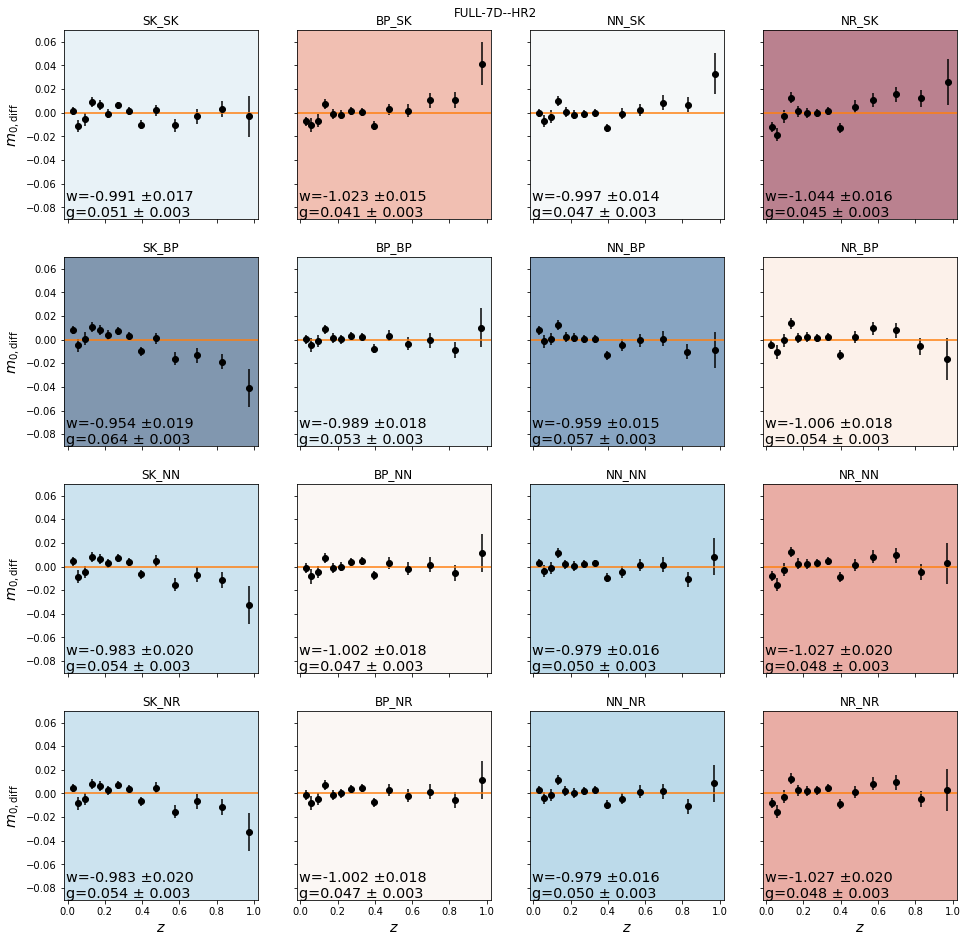

In [246]:
order = ['SK', 'BP', 'NN', 'NR']
n = -1
opt_dir = glob.glob('../../../Data/sims/NN_COMBINE_*FULL*')
runs = [k.split('_')[-1] for k in opt_dir]

fig, axs = plt.subplots(4, 4, figsize=[16,16], sharex=True, sharey=True)
for i, s in enumerate(order):
    for k, z in enumerate(order):
        n += 1
        checkit = checkthem[rc.value][z][s]['00'+str(MUO.value)]
        checkit.show_modif(axs[i][k], show_leg=False)
        axs[i][k].set_facecolor(bg_vals(0.5)[n])
        axs[i][k].axhline(0, color='C1')
        axs[i][k].set_title(checkit.name.split('_')[1] + '_' + checkit.name.split('_')[-1])
        # axs[i][k].set_ylim(-0.025, 0.100)
        axs[i][k].set_ylim(-0.090, 0.070)
        axs[i][k].text(0.01, 0.01,
                       f'w={float(checkit.wfit.w.values[0]):.3f} ±' +
                       f'{float(checkit.wfit.w_err.values[0]):.3f}\n' +
                       f'g={checkit.gab.gamma.values[0]:.3f} ± {checkit.gab.gamma_err.values[0]:.3f}',
                       transform=axs[i][k].transAxes,
                       fontsize='x-large')
        if n < 12:
            axs[i][k].set_xlabel('')
        else:
            axs[i][k].set_xlabel(r'$z$', fontsize='x-large')
        if k == 0:
            axs[i][k].set_ylabel(r'$m_{0, \rm{ diff}}$', fontsize='x-large')
            
fig.suptitle(checkit.name.split('_')[0] + '--' + 'HR' + str(MUO.value), y=0.90)
fig.savefig(f'../../../Images/pdf/HR_covmat-{rc.value}_{MUO.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/HR_covmat-{rc.value}_{MUO.value}.png', bbox_inches='tight', dpi=600)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:34: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:30: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:34: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:30: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


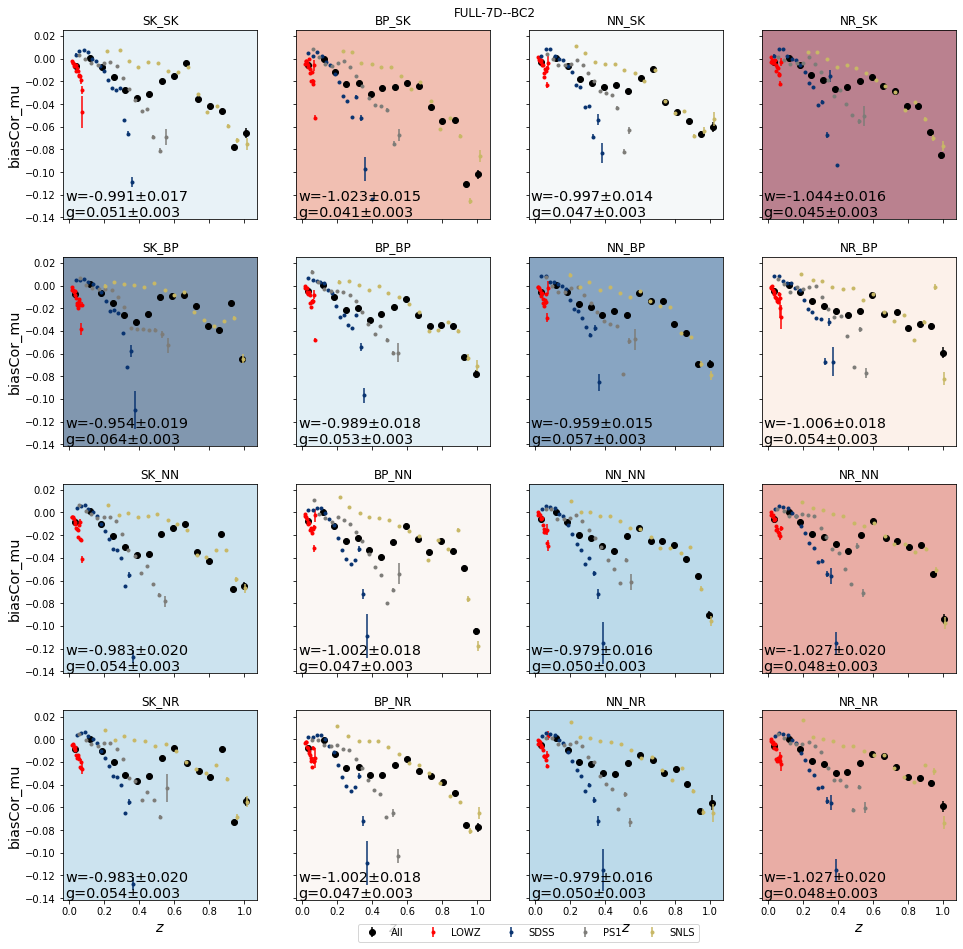

In [247]:
order = ['SK', 'BP', 'NN', 'NR']
n = -1

pd.set_option('mode.chained_assignment', None)

fig, axs = plt.subplots(4, 4, figsize=[16,16], sharex=True, sharey=True)
for i, s in enumerate(order):
    for k, z in enumerate(order):
        n += 1
        checkit = checkthem[rc.value][z][s]['00'+str(MUO.value)]
        checkit.sims_data['zBIN'] = pd.cut(checkit.sims_data.zCMB, 15)
        checkit.sims_datag = checkit.sims_data.groupby('zBIN').mean()
        checkit.sims_datag['biasCor_mu_err'] = \
            checkit.sims_data.groupby('zBIN')['biasCor_mu'].std() /\
            checkit.sims_data.groupby('zBIN')['biasCor_mu'].size()
        axs[i][k].errorbar(checkit.sims_datag.zCMB,
                           checkit.sims_datag.biasCor_mu,
                           yerr=checkit.sims_datag.biasCor_mu_err,
                           fmt='o', color='k',
                           zorder=1, label='All')
        BC = {survey: checkit.sims_data[checkit.sims_data['IDSURVEY'].isin(idsurvey)]
               for survey, idsurvey in zip(surveys[1:-1],
                                           [[5, 64, 65, 66], [1], [15], [4]])}
        BCg = dict()
        for survey in surveys[1:-1]:
            BC[survey]['zBIN'] = pd.cut(BC[survey].zCMB, 15)
            BCg[survey] = BC[survey].groupby('zBIN').mean()
            BCg[survey]['biasCor_mu_err'] = \
                BC[survey].groupby('zBIN')['biasCor_mu'].std() /\
                BC[survey].groupby('zBIN')['biasCor_mu'].size()
            axs[i][k].errorbar(BCg[survey].zCMB,
                               BCg[survey].biasCor_mu,
                               yerr=BCg[survey].biasCor_mu_err,
                               fmt='.', color=colors[survey], label=survey)
        axs[i][k].set_facecolor(bg_vals(0.5)[n])
        # axs[i][k].axhline(0, color='C1')
        axs[i][k].set_title(checkit.name.split('_')[1] + '_' + checkit.name.split('_')[-1])
        # axs[i][k].set_ylim(-0.025, 0.100)
        # axs[i][k].set_ylim(-0.090, 0.070)
        axs[i][k].text(0.01, 0.01,
                       f'w={float(checkit.wfit.w.values[0]):.3f}±' +
                       f'{float(checkit.wfit.w_err.values[0]):.3f}\n' +
                       f'g={checkit.gab.gamma.values[0]:.3f}±' +
                       f'{checkit.gab.gamma_err.values[0]:.3f}',
                       transform=axs[i][k].transAxes,
                       fontsize='x-large')
        if n < 12:
            axs[i][k].set_xlabel('')
        else:
            axs[i][k].set_xlabel(r'$z$', fontsize='x-large')
        if k == 0:
            axs[i][k].set_ylabel('biasCor_mu', fontsize='x-large')

axs[3][1].legend(ncol=5, loc='lower center', bbox_to_anchor=(1.2, -0.25))
            
fig.suptitle(checkit.name.split('_')[0] + '--' + 'BC' + str(MUO.value), y=0.90)
fig.savefig(f'../../../Images/pdf/BC_covmat-{rc.value}_{MUO.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/BC_covmat-{rc.value}_{MUO.value}.png', bbox_inches='tight', dpi=600)

In [208]:
def delta(z, K=0.87, Phi=2.8):
    '''Gives the fraction of young SNe Ia as a function of redshift;
    taken from https://arxiv.org/abs/1806.03849'''
    return (K**(-1)*(1+z)**(-Phi)+1)**(-1)

def gdelta(z, K=0.87, Phi=2.8):
    return(0.130*delta(z, K, Phi) - 0.065)

In [222]:
m_df

{'FULL-1D': {'NR': {'SK': {}, 'BP': {}, 'NN': {}, 'NR': {}}},
 'FULL-7D': {'NR': {'SK': {'002': 4.3787877646438425},
   'BP': {'002': 4.316725438311131},
   'NN': {'002': 4.37333215268545},
   'NR': {'002': 4.206950732550973}}},
 'FULL-BN': {'NR': {'SK': {}, 'BP': {}, 'NN': {}, 'NR': {}}}}

SK_SK 1.0029336666666666
LOWZ
SDSS
PS1
SNLS
BP_SK 0.9953665625
LOWZ
SDSS
PS1
SNLS
NN_SK 1.0061153333333333
LOWZ
SDSS
PS1


/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:34: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:30: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:34: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:30: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


SNLS
NR_SK 1.007144090909091
LOWZ
SDSS
PS1
SNLS
SK_BP 1.002421875
LOWZ
SDSS
PS1
SNLS
BP_BP 0.9937671052631579
LOWZ
SDSS
PS1
SNLS
NN_BP 1.00906
LOWZ
SDSS
PS1
SNLS
NR_BP 1.00452
LOWZ
SDSS
PS1
SNLS
SK_NN 1.008348125
LOWZ
SDSS
PS1
SNLS
BP_NN 0.9892731578947368
LOWZ
SDSS
PS1
SNLS
NN_NN 1.0000435714285714


/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:34: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:30: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


LOWZ
SDSS
PS1
SNLS
NR_NN 1.0051796666666666
LOWZ
SDSS
PS1
SNLS
SK_NR 1.001733
LOWZ
SDSS
PS1
SNLS
BP_NR 1.009683076923077
LOWZ
SDSS
PS1
SNLS
NN_NR 0.9944966666666667
LOWZ
SDSS
PS1
SNLS
NR_NR 1.001899642857143
LOWZ
SDSS
PS1
SNLS


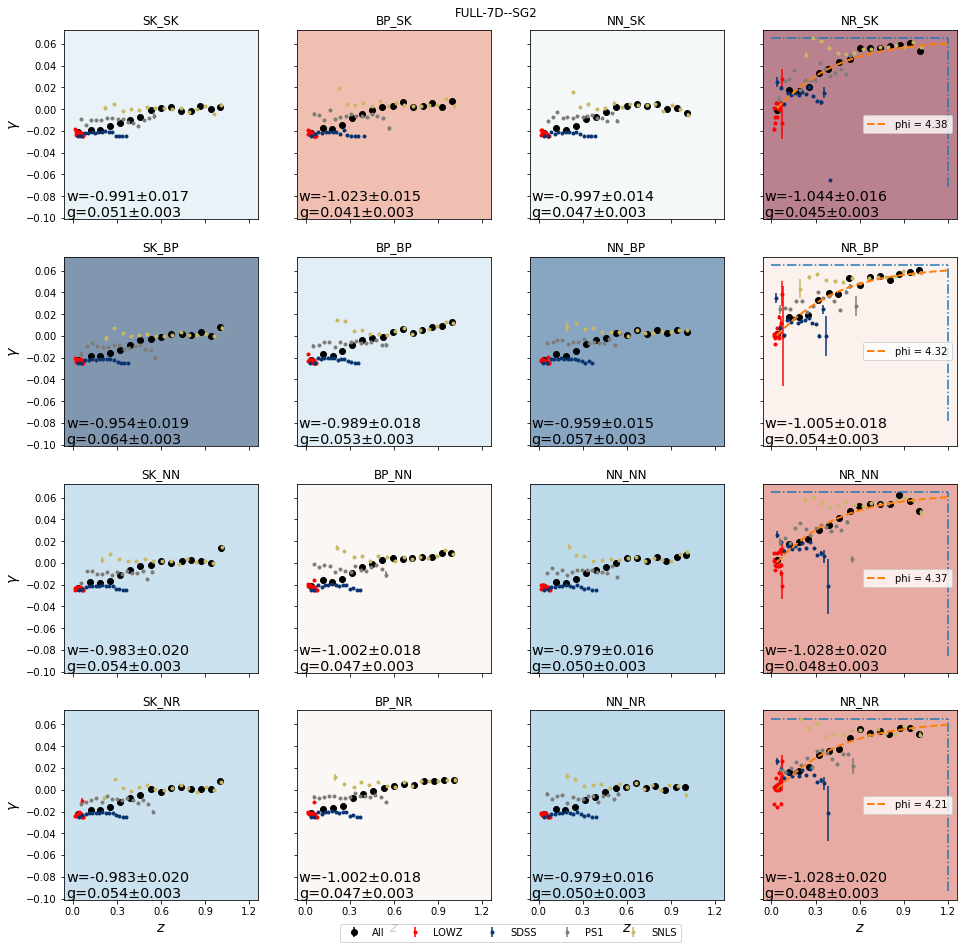

In [234]:
order = ['SK', 'BP', 'NN', 'NR']
n = -1

pd.set_option('mode.chained_assignment', None)

m_df = {run: {'NR': {s: dict()
                  for s in order}}
        for run in runs}

fig, axs = plt.subplots(4, 4, figsize=[16,16], sharex=True, sharey=True)
for i, s in enumerate(order):
    for k, z in enumerate(order):
        n += 1
        checkit = checkthem[rc.value][z][s]['00'+str(MUO.value)]
        checkit.sims_data['zBIN'] = pd.cut(checkit.sims_data.zCMB, 15)
        checkit.sims_datag = checkit.sims_data.groupby('zBIN').mean()
        checkit.sims_datag['SIM_gammaDM_err'] = \
            checkit.sims_data.groupby('zBIN')['SIM_gammaDM'].std() /\
            checkit.sims_data.groupby('zBIN')['SIM_gammaDM'].size()
        axs[i][k].errorbar(checkit.sims_datag.zCMB,
                           checkit.sims_datag.SIM_gammaDM,
                           yerr=checkit.sims_datag.SIM_gammaDM_err,
                           fmt='o', color='k',
                           zorder=1, label='All')
        print(checkit.name.split('_')[1] + '_' + checkit.name.split('_')[-1],
              np.max(checkit.sims_datag.zCMB))
        BC = {survey: checkit.sims_data[checkit.sims_data['IDSURVEY'].isin(idsurvey)]
               for survey, idsurvey in zip(surveys[1:-1],
                                           [[5, 64, 65, 66], [1], [15], [4]])}
        BCg = dict()
        for survey in surveys[1:-1]:
            BC[survey]['zBIN'] = pd.cut(BC[survey].zCMB, 15)
            print(survey)
            BCg[survey] = BC[survey].groupby('zBIN').mean()
            BCg[survey]['SIM_gammaDM_err'] = \
                BC[survey].groupby('zBIN')['SIM_gammaDM'].std() /\
                BC[survey].groupby('zBIN')['SIM_gammaDM'].size()
            axs[i][k].errorbar(BCg[survey].zCMB,
                               BCg[survey].SIM_gammaDM,
                               yerr=BCg[survey].SIM_gammaDM_err,
                               fmt='.', color=colors[survey], label=survey)
        axs[i][k].set_facecolor(bg_vals(0.5)[n])
        # axs[i][k].axhline(0, color='C1')
        axs[i][k].set_title(checkit.name.split('_')[1] + '_' + checkit.name.split('_')[-1])
        # axs[i][k].set_ylim(-0.025, 0.100)
        # axs[i][k].set_ylim(-0.090, 0.070)
        axs[i][k].text(0.01, 0.01,
                       f'w={float(checkit.wfit.w.values[0]):.3f}±' +
                       f'{float(checkit.wfit.w_err.values[0]):.3f}\n' +
                       f'g={checkit.gab.gamma.values[0]:.3f}±' +
                       f'{checkit.gab.gamma_err.values[0]:.3f}',
                       transform=axs[i][k].transAxes,
                       fontsize='x-large')
        start, end = axs[i][k].get_xlim()
        axs[i][k].xaxis.set_ticks(np.arange(0, np.ceil(end), 0.3))
        if n < 12:
            axs[i][k].set_xlabel('')
        else:
            axs[i][k].set_xlabel(r'$z$', fontsize='x-large')
        if k == 0:
            axs[i][k].set_ylabel(r'$\gamma$', fontsize='x-large')
        if k == 3:
            def chi2(K, Phi):
                return np.sum((checkit.sims_datag.SIM_gammaDM -
                               gdelta(checkit.sims_datag.zCMB, K, Phi))**2 /
                              checkit.sims_datag.SIM_gammaDM_err**2)
            m = im.Minuit(chi2, K=0.87, Phi=2.8)
            m.limits = [None, (2, 5)]
            m.errordef = im.Minuit.LEAST_SQUARES
            m.fixed['K'] = True
            m.migrad()
            m_df[rc.value][z][s]['00'+str(MUO.value)] = m.values['Phi']
            zz = np.linspace(np.min(checkit.sims_datag.zCMB),
                             #np.max(checkit.sims_datag.zCMB),
                             1.2,
                             1000)
            # gmean_a = gdelta(zz, Phi=2.8)
            # gmean_b = gdelta(zz, Phi=3.5)
            # gmean_c = gdelta(zz, Phi=4.0)
            gmean_d = gdelta(zz, Phi=m.values['Phi'])
            # axs[i][k].plot(zz, gmean_a,
            #                ls='--', lw=2, color='C1',
            #                zorder=6, label=r'$\mathrm{gm}(z, \phi=2.8)$')
            # axs[i][k].plot(zz, gmean_b,
            #                ls='--', lw=2, color='C2',
            #                zorder=6, label=r'$\mathrm{gm}(z, \phi=3.5)$')
            # axs[i][k].plot(zz, gmean_c,
            #                ls='--', lw=2, color='C3',
            #                zorder=6, label=r'$\mathrm{gm}(z, \phi=4.0)$')
            toleg = axs[i][k].plot(zz, gmean_d,
                                   ls='--', lw=2, color='C1',
                                   zorder=6)
            xlim = axs[i][k].get_xlim()
            ylim = axs[i][k].get_ylim()
            axs[i][k].plot([0, 1.2],
                           [0.065, 0.065], c='C0', ls='-.')
            axs[i][k].plot([1.2, 1.2],
                           [ylim[0], 0.065], c='C0', ls='-.')
            axs[i][k].legend(toleg, [f'phi = {m.values["Phi"]:.2f}'], loc='center right')

axs[3][1].legend(ncol=6, loc='lower center', bbox_to_anchor=(1.1, -0.25))
            
fig.suptitle(checkit.name.split('_')[0] + '--' + 'SG' + str(MUO.value), y=0.90)
fig.savefig(f'../../../Images/pdf/GR_covmat-{rc.value}_{MUO.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/GR_covmat-{rc.value}_{MUO.value}.png', bbox_inches='tight', dpi=600)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:34: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:30: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:34: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:30: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:34: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axi

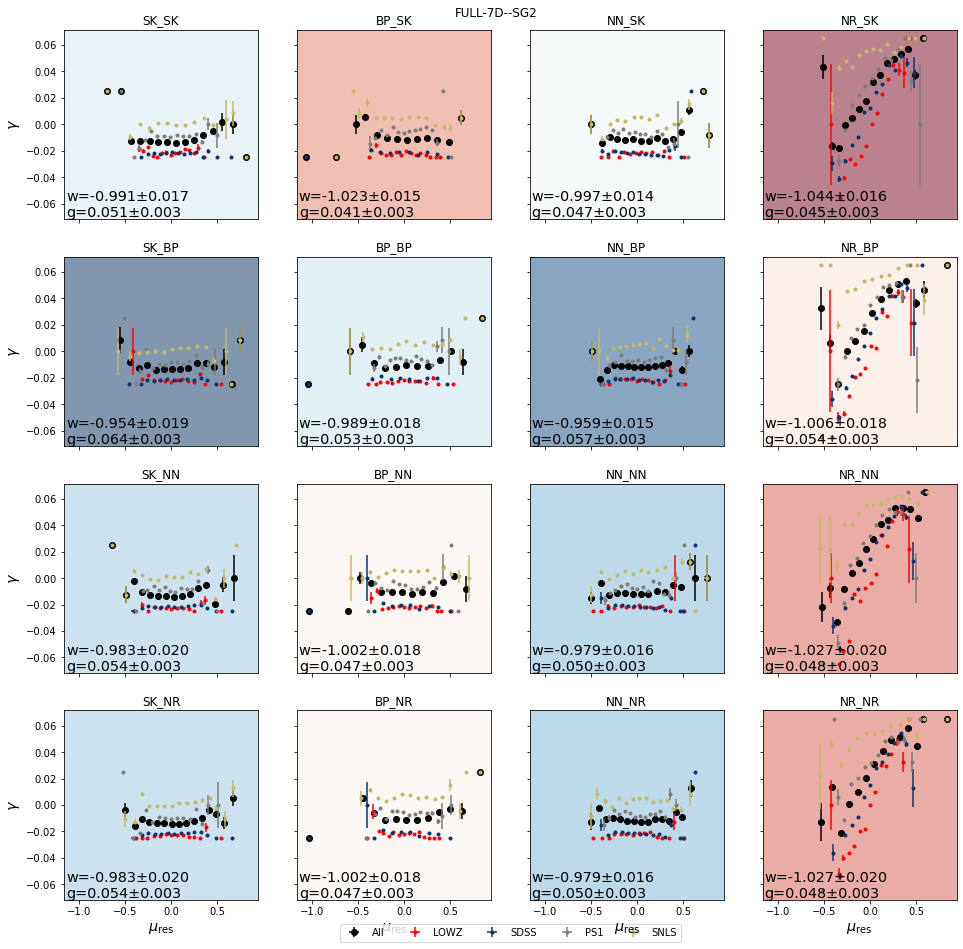

In [249]:
order = ['SK', 'BP', 'NN', 'NR']
n = -1

pd.set_option('mode.chained_assignment', None)

m_df = {run: {'NR': {s: dict()
                  for s in order}}
        for run in runs}

fig, axs = plt.subplots(4, 4, figsize=[16,16], sharex=True, sharey=True)
for i, s in enumerate(order):
    for k, z in enumerate(order):
        n += 1
        checkit = checkthem[rc.value][z][s]['00'+str(MUO.value)]
        checkit.sims_data['mBIN'] = pd.cut(checkit.sims_data.MURES, 15)
        checkit.sims_datag = checkit.sims_data.groupby('mBIN').mean()
        checkit.sims_datag['SIM_gammaDM_err'] = \
            checkit.sims_data.groupby('mBIN')['SIM_gammaDM'].std() /\
            checkit.sims_data.groupby('mBIN')['SIM_gammaDM'].size()
        checkit.sims_datag['MURES_err'] = \
            checkit.sims_data.groupby('mBIN')['MURES'].std() /\
            checkit.sims_data.groupby('mBIN')['MURES'].size()
        axs[i][k].errorbar(checkit.sims_datag.MURES,
                           checkit.sims_datag.SIM_gammaDM,
                           xerr=checkit.sims_datag.MURES_err,
                           yerr=checkit.sims_datag.SIM_gammaDM_err,
                           fmt='o', color='k',
                           zorder=1, label='All')
        BC = {survey: checkit.sims_data[checkit.sims_data['IDSURVEY'].isin(idsurvey)]
               for survey, idsurvey in zip(surveys[1:-1],
                                           [[5, 64, 65, 66], [1], [15], [4]])}
        BCg = dict()
        for survey in surveys[1:-1]:
            BC[survey]['mBIN'] = pd.cut(BC[survey].MURES, 15)
            BCg[survey] = BC[survey].groupby('mBIN').mean()
            BCg[survey]['SIM_gammaDM_err'] = \
                BC[survey].groupby('mBIN')['SIM_gammaDM'].std() /\
                BC[survey].groupby('mBIN')['SIM_gammaDM'].size()
            BCg[survey]['MURES_err'] = \
                BC[survey].groupby('mBIN')['MURES'].std() /\
                BC[survey].groupby('mBIN')['MURES'].size()
            axs[i][k].errorbar(BCg[survey].MURES,
                               BCg[survey].SIM_gammaDM,
                               xerr=BCg[survey].MURES_err,
                               yerr=BCg[survey].SIM_gammaDM_err,
                               fmt='.', color=colors[survey], label=survey)
        axs[i][k].set_facecolor(bg_vals(0.5)[n])
        # axs[i][k].axhline(0, color='C1')
        axs[i][k].set_title(checkit.name.split('_')[1] + '_' + checkit.name.split('_')[-1])
        # axs[i][k].set_ylim(-0.025, 0.100)
        # axs[i][k].set_ylim(-0.090, 0.070)
        axs[i][k].text(0.01, 0.01,
                       f'w={float(checkit.wfit.w.values[0]):.3f}±' +
                       f'{float(checkit.wfit.w_err.values[0]):.3f}\n' +
                       f'g={checkit.gab.gamma.values[0]:.3f}±' +
                       f'{checkit.gab.gamma_err.values[0]:.3f}',
                       transform=axs[i][k].transAxes,
                       fontsize='x-large')
        # start, end = axs[i][k].get_xlim()
        # axs[i][k].xaxis.set_ticks(np.arange(0, np.ceil(end), 0.3))
        if n < 12:
            axs[i][k].set_xlabel('')
        else:
            axs[i][k].set_xlabel(r'$\mu_{\rm res}$', fontsize='x-large')
        if k == 0:
            axs[i][k].set_ylabel(r'$\gamma$', fontsize='x-large')
            
axs[3][1].legend(ncol=6, loc='lower center', bbox_to_anchor=(1.1, -0.25))
            
fig.suptitle(checkit.name.split('_')[0] + '--' + 'SG' + str(MUO.value), y=0.90)
fig.savefig(f'../../../Images/pdf/GRvMR_covmat-{rc.value}_{MUO.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/GRvMR_covmat-{rc.value}_{MUO.value}.png', bbox_inches='tight', dpi=600)

### $w$

In [68]:
if 'V' in rc.value:
    order = ['SK', 'BP', 'NN', 'NR']
    # order = ['SK', 'NN', 'NR']
else:
    order = ['SK', 'BP', 'NN', 'NR']
data_show = {name: dict() for name in order}
erro_show = {name: dict() for name in order}
for i in order:
    for k in order:
        wall = tools.Checker.read(f'../../../Data/sims/NN_COMBINE_{rc.value}/6_BIASCOR/' +
                                  f'ALL_BIASCOR_{i}_{k}/output/BBC_SUMMARY_wfit.FITRES')
        walla = wall[wall['MUOPT'] == MUO.value]
        data_show[i][k] = float(np.mean(walla.w))
        if 'FULL' in rc.value:
            erro_show[i][k] = walla.wsig.values[0]
        else:
            erro_show[i][k] = np.std(walla.w)/np.sqrt(len(walla))
data_show = pd.DataFrame(data_show)

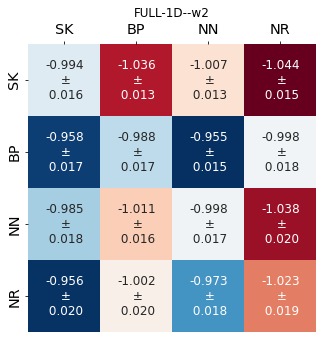

In [69]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

cbarlb = {'label': r'$w$ values',
          'fraction':0.05}#,
          #'labelsize': 'x-large'} #'aspect':50,
    
akws = {'fontsize': 'large'}

if 'V' in rc.value:
    xticklabels=['SK', 'BP', 'NN', 'NR']
    yticklabels=['SK', 'BP', 'NN', 'NR']
    # xticklabels=['SK', 'NN', 'NR']
    # yticklabels=['SK', 'NN', 'NR']
    # xticklabels=[]
    # yticklabels=[]
else:
    xticklabels=['SK', 'BP', 'NN', 'NR']
    yticklabels=['SK', 'BP', 'NN', 'NR']
    # xticklabels=['SK', 'BP', 'NN']
    # yticklabels=['SK', 'BP', 'NN']
    # xticklabels=[]
    # yticklabels=[]
    
labels = [[f'{data_show[k][i]:.3f}\n ±\n {erro_show[k][i]:.3f}'
           for k in order]
          for i in order]
labels_z = [[f'{data_show[k][i]+1:.4f}\n ±\n {erro_show[k][i]:.4f}'
             for k in order]
            for i in order]

center = -1
cmap = mpl.cm.get_cmap('RdBu')
# data_show_diverr = (data_show+1)/0.0026
data_show_diverr = (data_show+1)/0.0026

sn.heatmap(data_show, ax=ax,
           annot=labels, annot_kws=akws, fmt='',
           cmap=cmap, center=center,
           # vmin=-5, vmax=5,
           cbar=False, #cbar_kws=cbarlb,
           xticklabels=xticklabels,
           yticklabels=yticklabels)

im = ax.collections[0]
rgba_values = im.cmap(im.norm(im.get_array()))

ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')

ax.tick_params(labelsize='x-large')

ax.set_title(rc.value + '--' + 'w' + str(MUO.value))

# fig.savefig(f'../../../Images/pdf/gfit_covmat_{rc.value}_{MUO.value}.pdf', bbox_inches='tight')
# fig.savefig(f'../../../Images/png/gfit_covmat_{rc.value}_{MUO.value}.png', bbox_inches='tight', dpi=600)

fig.savefig(f'../../../Images/pdf/wfit_covmat_{rc.value}_{MUO.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/wfit_covmat_{rc.value}_{MUO.value}.png', bbox_inches='tight', dpi=600)

#### Histograms

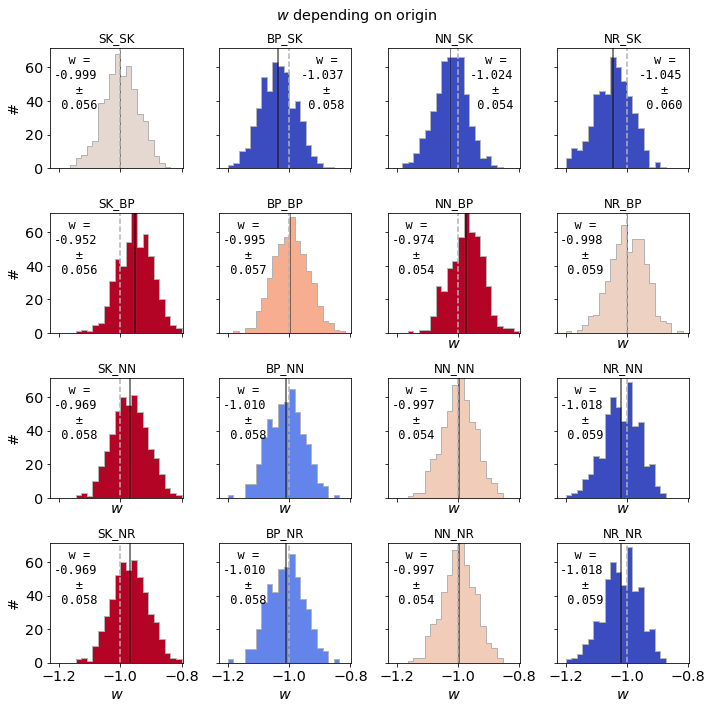

In [83]:
order = ['SK', 'BP', 'NN', 'NR']

n = -1
wmin = []
wmax = []

fig, ax = plt.subplots(4, 4, figsize=[10, 10], sharex=True, sharey=True)
for i,s in enumerate(order):
    for k,z in enumerate(order):
        n += 1
        wlist = tools.Checker.read(f'../../../Data/sims/NN_COMBINE_{FoS.value}/' +
                                  f'ALL_BIASCOR_{z}_{s}/output/BBC_SUMMARY_wfit.FITRES')
        wlist = wlist[wlist['MUOPT'] == 0]
        wmin.append(np.min(wlist.w))
        wmax.append(np.max(wlist.w))
        
        ax[i][k].hist(wlist.w,
                      range=(-1.2, -0.8), bins=22,
                      histtype='stepfilled',
                      color=rgba_values[n],
                      ec='0.7')
        ylim = ax[i][k].get_ylim()
        
        # ax[i][k].vline(np.mean(wlist.w), color='0.7', lw=0.5)
        werr = (np.std(wlist.w)/np.sqrt(500)) 
        ax[i][k].vspan(np.mean(wlist.w)+werr,
                       np.mean(wlist.w)-werr,
                       facecolor='k', edgecolor='w',
                       lw=0.1, alpha=.5)
        ax[i][k].vline(-1.0, ls='--', c='0.7')
        
        ax[i][k].set_ylim(ylim)
        
        mono = {'family' : 'monospace'}
        if 1 <= n <= 3:
            ax[i][k].text(0.95, 0.95,
                          f'w = \n{np.mean(wlist.w):.3f}\n±  \n {np.std(wlist.w):.3f}',
                          fontsize='large',
                          ha='right', va='top',
                          transform=ax[i][k].transAxes,
                          fontdict=mono)
        else:
            ax[i][k].text(0.025, 0.95,
                          f'  w =\n{np.mean(wlist.w):.3f}\n   ± \n {np.std(wlist.w):.3f}',
                          fontsize='large',
                          ha='left', va='top',
                          transform=ax[i][k].transAxes,
                          fontdict=mono)
        
        # ax[i][k].set_facecolor('0.9')
        
        ax[i][k].tick_params(labelsize='x-large')
        if n < 6:
            pass
        else:
            ax[i][k].set_xlabel(r'$w$', fontsize='x-large')
        if k > 0:
            pass
        else:
            ax[i][k].set_ylabel('#', fontsize='x-large')
        ax[i][k].set_title(f'{z}_{s}')

wmin = 1.01*np.min(wmin)
wmax = 0.99*np.max(wmax)

for i in range(3):
    for k in range(3):
        ax[i][k].set_xlim(wmin, wmax)
    
fig.suptitle(r'$w$ depending on origin', fontsize='x-large')

fig.tight_layout()

fig.savefig(f'../../../Images/pdf/wfit_hists-{FoS.value}_{MUO.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/wfit_hists-{FoS.value}_{MUO.value}.png', bbox_inches='tight', dpi=600)

In [33]:
wfit_sk_sk = pd.read_csv('../../../Data/sims/wfit_sk_sk.tsv', delimiter='\t')

Text(0.5, 1.0, 'SK_SK')

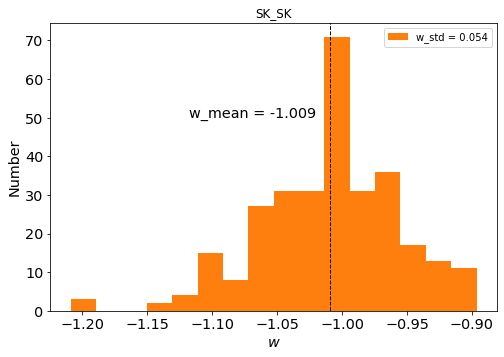

In [66]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

w_l = wfit_sk_sk.w
wmen = np.mean(w_l)
wstd = np.std(w_l)
ax.hist(w_l, bins='auto', color='C1', label=f'w_std = {wstd:.03f}')
ax.vline(wmen, lw=1, color='k', ls='--')
ax.text(-1.02, 50, s=f'w_mean = {wmen:.03f}', ha='right', fontsize='x-large')

ax.tick_params(labelsize='x-large')
    
ax.set_xlabel(r'$w$', fontsize='x-large')
ax.set_ylabel(r'Number', fontsize='x-large')

ax.legend()

ax.set_title('SK_SK')

Text(0.5, 1.0, 'SK_SK')

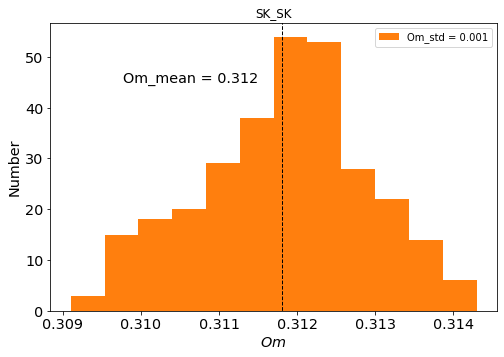

In [70]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

Om_l = wfit_sk_sk.omm
Ommen = np.mean(Om_l)
Omstd = np.std(Om_l)
ax.hist(Om_l, bins='auto', color='C1', label=f'Om_std = {Omstd:.03f}')
ax.vline(Ommen, lw=1, color='k', ls='--')
ax.text(0.3115, 45, s=f'Om_mean = {Ommen:.03f}', ha='right', fontsize='x-large')

ax.tick_params(labelsize='x-large')
    
ax.set_xlabel(r'$Om$', fontsize='x-large')
ax.set_ylabel(r'Number', fontsize='x-large')

ax.legend()

ax.set_title('SK_SK')

### Development for binned residuals

In [153]:
nbins = 100
_, bins = np.histogram(checkit.sims_data.zCMB, bins=nbins)

slices = []
for i in range(nbins):
    slices.append(np.where((checkit.sims_data.zCMB > bins[i])
                           & (checkit.sims_data.zCMB <= bins[i+1]))[0])

#### Fit Gaussian stretch to each bin

In [170]:
def gauss(x, dx, mu, sigma, normed=True):
    '''Le modèle de distribution'''
    sigma_eff = np.sqrt(dx**2+sigma**2)
    norm = 1 if normed else np.sqrt(2*np.pi)*sigma_eff
    return norm*scipy.stats.norm.pdf(x, mu, scale=sigma_eff)

GUESS = {'mu': 0., 'sigma': 0.25}

def minimize(nslice):
    '''Meilleure valeur des paramètres'''
    def loglikelihood(mu, sigma):
        '''La fonction à minimiser'''
        return -2*np.sum(np.log(gauss(checkit.sims_data.MURES.values[slices[nslice]],
                                      checkit.sims_data.MUERR.values[slices[nslice]],
                                      mu, sigma)))
    m_tot = im.Minuit(loglikelihood, **GUESS)
    migrad_out = m_tot.migrad()
    return m_tot

#### Computation of means and averages

In [192]:
z_comp_mean = np.zeros(nbins)
z_comp_std = np.zeros(nbins)
mu_comp_mean = np.zeros(nbins)
mu_comp_average = np.zeros(nbins)
mu_comp_std = np.zeros(nbins)

for i in range(nbins):
    if len(slices[i]) == 0:
        z_comp_mean[i] = -1
        z_comp_std[i] = -1
        mu_comp_mean[i] = -1
        mu_comp_average[i] = -1
        mu_comp_std[i] = -1
    else:
        z_comp_mean[i] = np.mean(checkit.sims_data.zCMB.values[slices[i]])
        z_comp_std[i] = np.std(checkit.sims_data.zCMB.values[slices[i]])
        mu_comp_mean[i] = np.mean(checkit.sims_data.MURES.values[slices[i]])
        mu_comp_average[i] = np.average(checkit.sims_data.MURES.values[slices[i]],
                                        weights=1/(checkit.sims_data.MUERR.values[slices[i]]**2 +
                                                   minimize(i).values[-1]**2))
        mu_comp_std[i] = np.std(checkit.sims_data.MURES.values[slices[i]])

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)


#### Choose mean method

In [186]:
mean_c = ipw.Dropdown(options=['mean', 'weighted'],
                      value='mean',
                      description='Type of mean:')

display(mean_c)

Dropdown(description='Type of mean:', options=('mean', 'weighted'), value='mean')

#### Ok plot I guess

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


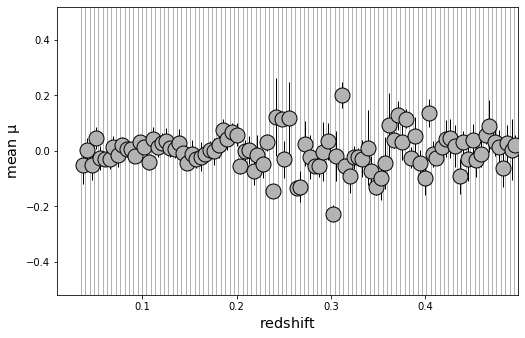

In [200]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop2 = dict(marker="o", ms=15, ecolor="0.7", mew=1, mec="0.5")
prop = dict(marker="o", ms=15, ecolor="k", mew=1, mec="k", mfc="0.7")

cmap = 'inferno'

#vmap_v = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(bins)))
for i in range(len(bins)):
    ax.vline(bins[i], color="0.7", lw=1)

#############################################################################################

if mean_c.value == 'mean':
    for i in range(nbins):
        ax.errorbar(z_comp_mean[i], mu_comp_mean[i],
                    xerr=z_comp_std[i]/np.sqrt(len(checkit.sims_data.zCMB.values[slices[i]])),
                    yerr=mu_comp_std[i]/np.sqrt(len(checkit.sims_data.MUERR.values[slices[i]])),
                    **prop, zorder=10, lw=1)
else:
    for i in range(nbins):
        ax.errorbar(z_comp_mean[i], mu_comp_average[i],
                    xerr=z_comp_std[i]/np.sqrt(len(checkit.sims_data.zCMB.values[slices[i]])),
                    yerr=mu_comp_std[i]/np.sqrt(len(checkit.sims_data.MUERR.values[slices[i]])),
                    **prop, zorder=10, lw=1)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,\mu}$ ", fontsize="x-large")

#############################################################################################

ax.set_ylim(-0.52, 0.52)
ax.set_xlim(0.01, np.max(checkit.sims_data.zCMB))
#ax.set_xscale('log')

#ax.legend(ncol=4, loc='upper center', columnspacing=1.4)

fig.savefig(f'../../../Images/pdf/{filename}_mudiff-binned_{mean_c.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/{filename}_mudiff-binned_{mean_c.value}.png', bbox_inches='tight', dpi=600)

### Ssize plots and new NGEN calc

In [21]:
surveys_size = {survey:
                len(df_full[df_full['survey'] == survey])
                 for survey in surveys[1:-1]}
surveys_size

{'LOWZ': 172, 'SDSS': 335, 'PS1': 279, 'SNLS': 236}

#### For all

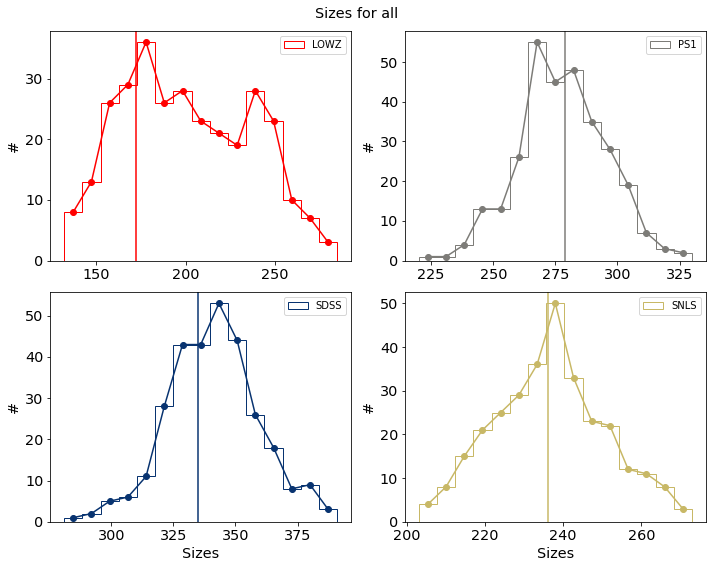

In [160]:
ssizes = pd.read_csv('../../../Data/sims/split_sizes-ALL.tsv', delimiter='\t')

fig, axs = plt.subplots(2, 2, figsize=[10,8])

i = -1

for a in range(2):
    for b in range(2):
        i += 1
        survey = ssizes.columns[i]
        hist = axs[a][b].hist(ssizes[survey],
                              histtype='step', bins=15,
                              color=colors[survey],
                              label=survey)
        xlim = axs[a][b].get_xlim()
        ylim = axs[a][b].get_ylim()
        axs[a][b].vline(surveys_size[survey], color=colors[survey])
        axs[a][b].plot(
            (hist[1][:-1]+hist[1][1:])/2,
            hist[0], marker='o',
            color=colors[survey])
        axs[a][b].set_xlim(xlim)
        axs[a][b].set_ylim(ylim)
        axs[a][b].tick_params(labelsize='x-large')
        if i < 2:
            pass
        else:
            axs[a][b].set_xlabel('Sizes', fontsize='x-large')
        axs[a][b].set_ylabel('#', fontsize='x-large')
        axs[a][b].legend()
        # axs[a][b].set_title(survey)
    
fig.suptitle('Sizes for all', fontsize='x-large')

fig.tight_layout()

fig.savefig(f'../../../Images/pdf/ssizes_all.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/ssizes_all.png', bbox_inches='tight', dpi=600)

#### Per survey

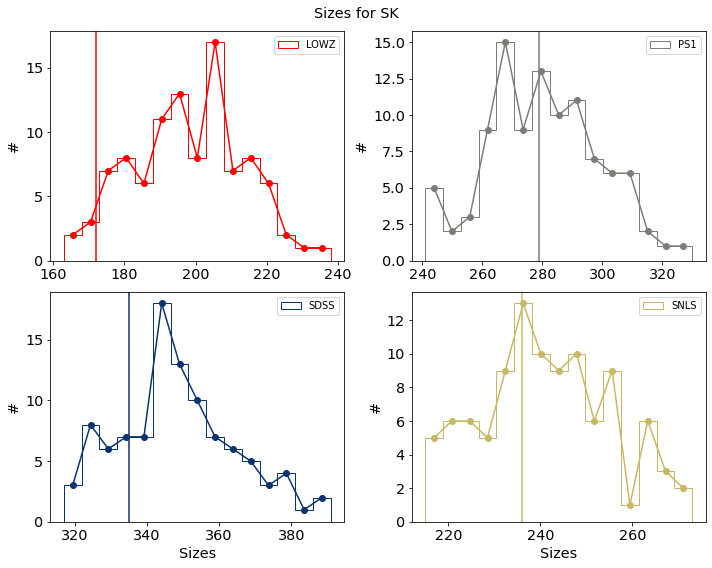

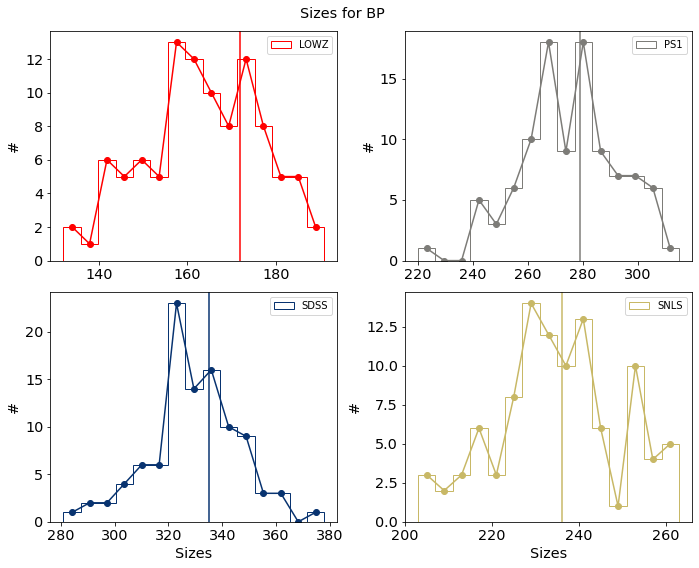

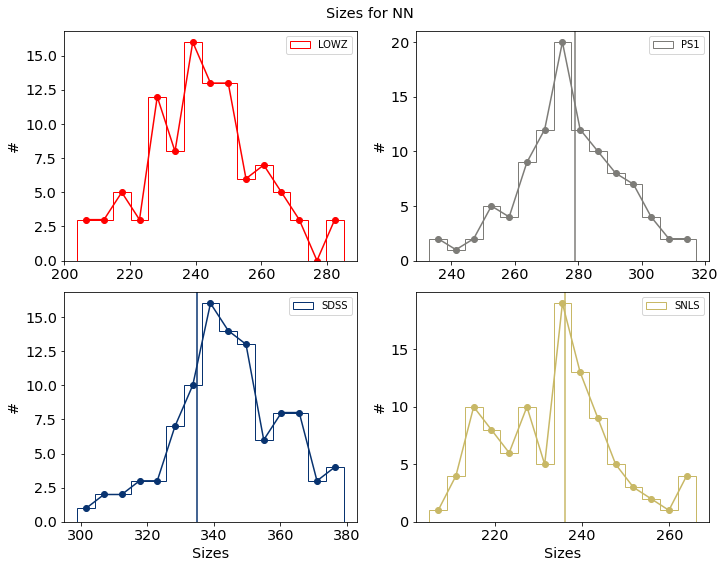

In [163]:
ssizez = dict()
for s in order:
    ssizez[s] = pd.read_csv(f'../../../Data/sims/split_sizes-{s}.tsv',
                            delimiter='\t')

    fig, axs = plt.subplots(2, 2, figsize=[10,8])
    
    i = -1
    
    for a in range(2):
        for b in range(2):
            i += 1
            survey = ssizez[s].columns[i]
            hist = axs[a][b].hist(ssizez[s][survey],
                                  histtype='step', bins=15,
                                  color=colors[survey],
                                  label=survey)
            xlim = axs[a][b].get_xlim()
            ylim = axs[a][b].get_ylim()
            axs[a][b].vline(surveys_size[survey], color=colors[survey])
            axs[a][b].plot(
                (hist[1][:-1]+hist[1][1:])/2,
                hist[0], marker='o',
                color=colors[survey])
            axs[a][b].set_xlim(xlim)
            axs[a][b].set_ylim(ylim)
            axs[a][b].tick_params(labelsize='x-large')
            if i < 2:
                pass
            else:
                axs[a][b].set_xlabel('Sizes', fontsize='x-large')
            axs[a][b].set_ylabel('#', fontsize='x-large')
            axs[a][b].legend()
            # axs[a][b].set_title(survey)
        
    fig.suptitle(f'Sizes for {s}', fontsize='x-large')
    
    fig.tight_layout()
    
    fig.savefig(f'../../../Images/pdf/ssizes_{s}.pdf', bbox_inches='tight')
    fig.savefig(f'../../../Images/png/ssizes_{s}.png', bbox_inches='tight', dpi=600)

### Compute NGEN vfull

#### On SIM

In [47]:
order = ['SK', 'BP', 'NN', 'NR']
vsizez = dict()
vsizer = dict()

surveys_size = {survey:
                len(df_full[df_full['survey'] == survey])
                 for survey in surveys[1:-1]}
surveysr = {survey: surveys_size[survey]/surveys_size['LOWZ']
            for survey in surveys[1:-1]}

for o in order:
    sim_path = glob.glob(f"../../../Data/sims/NN_COMBINE_VFULL/2_LCFIT/*SIM-{o}/output/PIP*/*.FITRES")
    fitres = pd.concat([tools.Checker.read(k) for k in sim_path])
    fitres_data = tools.Checker.sample_sims(fitres, df_full_data)
    vsizez[o] = {survey: len(fitres[fitres['IDSURVEY'].isin(idsurvey)])
                 for survey, idsurvey in zip(surveys[1:-1],
                                             [[5, 64, 65, 66], [1], [15], [4]])}
    vsizer[o] = {survey: vsizez[o][survey]/vsizez[o]['LOWZ']
                 for survey in surveys[1:-1]}

In [48]:
NGENs = {'SK': {'LOWZ': 18,
                'SDSS': 10.68,
                'SNLS': 5.16,
                'PS1': 6.95},
         'BP':{'LOWZ': 18,
                'SDSS': 10.68,
                'SNLS': 5.16,
                'PS1': 6.95},
         'NN':{'LOWZ': 18,
                'SDSS': 10.68,
                'SNLS': 5.16,
                'PS1': 6.95},
         'NR':{'LOWZ': 18,
                'SDSS': 10.68,
                'SNLS': 5.16,
                'PS1': 6.95}}
NGENss = {'SK': {},
          'BP': {},
          'NN': {},
          'NR': {}}

for o in order:
    for s in surveys[1:-1]:
        NGENss[o][s] = surveysr[s]*NGENs[o][s]/vsizer[o][s]*20/18

In [49]:
NGENss

{'SK': {'LOWZ': 20.0,
  'SDSS': 13.91834439663805,
  'PS1': 8.548783342073317,
  'SNLS': 5.367602246499613},
 'BP': {'LOWZ': 20.0,
  'SDSS': 12.274041738982087,
  'PS1': 7.277855484368418,
  'SNLS': 4.572517310735287},
 'NN': {'LOWZ': 20.0,
  'SDSS': 17.538821778545184,
  'PS1': 11.410314227831005,
  'SNLS': 7.256035600240286},
 'NR': {'LOWZ': 20.0,
  'SDSS': 17.538821778545184,
  'PS1': 11.410314227831005,
  'SNLS': 7.256035600240286}}

#### On DATA

In [50]:
order = ['SK', 'BP', 'NN', 'NR']
vsizez = dict()
vsizer = dict()

surveys_size = {survey:
                len(df_full[df_full['survey'] == survey])
                 for survey in surveys[1:-1]}
surveysr = {survey: surveys_size[survey]/surveys_size['LOWZ']
            for survey in surveys[1:-1]}

for o in order:
    sim_path = glob.glob(f"../../../Data/sims/NN_COMBINE_VFULL/2_LCFIT/*DATA-{o}/output/PIP*/*.FITRES")
    fitres = pd.concat([tools.Checker.read(k) for k in sim_path])
    fitres_data = tools.Checker.sample_sims(fitres, df_full_data)
    vsizez[o] = {survey: len(fitres[fitres['IDSURVEY'].isin(idsurvey)])
                 for survey, idsurvey in zip(surveys[1:-1],
                                             [[5, 64, 65, 66], [1], [15], [4]])}
    vsizer[o] = {survey: vsizez[o][survey]/vsizez[o]['LOWZ']
                 for survey in surveys[1:-1]}

In [51]:
NGENs = {'SK': {'LOWZ': 18,
                'SDSS': 10.68,
                'SNLS': 5.16,
                'PS1': 6.95},
         'BP':{'LOWZ': 18,
                'SDSS': 10.68,
                'SNLS': 5.16,
                'PS1': 6.95},
         'NN':{'LOWZ': 18,
                'SDSS': 10.68,
                'SNLS': 5.16,
                'PS1': 6.95},
         'NR':{'LOWZ': 18,
                'SDSS': 10.68,
                'SNLS': 5.16,
                'PS1': 6.95}}
NGENss = {'SK': {},
          'BP': {},
          'NN': {},
          'NR': {}}

for o in order:
    for s in surveys[1:-1]:
        NGENss[o][s] = surveysr[s]*NGENs[o][s]/vsizer[o][s]*20/18

In [52]:
NGENss

{'SK': {'LOWZ': 20.0,
  'SDSS': 14.1112951525641,
  'PS1': 8.76142859891934,
  'SNLS': 5.495845878347797},
 'BP': {'LOWZ': 20.0,
  'SDSS': 12.412146703804524,
  'PS1': 7.470492971187942,
  'SNLS': 4.714085033704232},
 'NN': {'LOWZ': 20.0,
  'SDSS': 17.57802494101786,
  'PS1': 11.6035683650128,
  'SNLS': 7.339902697921273},
 'NR': {'LOWZ': 20.0,
  'SDSS': 17.80436938040113,
  'PS1': 11.902729434271087,
  'SNLS': 7.571448539913094}}

#### On BBC_OUTPUT

In [53]:
order = ['SK', 'BP', 'NN', 'NR']
vsizez = dict()
vsizer = dict()

surveys_size = {survey:
                len(df_full[df_full['survey'] == survey])
                 for survey in surveys[1:-1]}
surveysr = {survey: surveys_size[survey]/surveys_size['LOWZ']
            for survey in surveys[1:-1]}

for o in order:
    sim_path = glob.glob(f"../../../Data/sims/NN_COMBINE_VFULL/6_BIASCOR/*{o}_*/output/OUTPUT*/*MUOPT000.FITRES")
    fitres = pd.concat([tools.Checker.read(k) for k in sim_path])
    vsizez[o] = {survey: len(fitres[fitres['IDSURVEY'].isin(idsurvey)])
                 for survey, idsurvey in zip(surveys[1:-1],
                                             [[5, 64, 65, 66], [1], [15], [4]])}
    vsizer[o] = {survey: vsizez[o][survey]/vsizez[o]['LOWZ']
                 for survey in surveys[1:-1]}

In [54]:
NGENs = {'SK': {'LOWZ': 18,
                'SDSS': 10.68,
                'SNLS': 5.16,
                'PS1': 6.95},
         'BP':{'LOWZ': 18,
                'SDSS': 10.68,
                'SNLS': 5.16,
                'PS1': 6.95},
         'NN':{'LOWZ': 18,
                'SDSS': 10.68,
                'SNLS': 5.16,
                'PS1': 6.95},
         'NR':{'LOWZ': 18,
                'SDSS': 10.68,
                'SNLS': 5.16,
                'PS1': 6.95}}
NGENss = {'SK': {},
          'BP': {},
          'NN': {},
          'NR': {}}

for o in order:
    for s in surveys[1:-1]:
        NGENss[o][s] = surveysr[s]*NGENs[o][s]/vsizer[o][s]*20/18

In [55]:
NGENss

{'SK': {'LOWZ': 20.0,
  'SDSS': 13.511875009393009,
  'PS1': 8.255766419578215,
  'SNLS': 6.5355160522053914},
 'BP': {'LOWZ': 20.0,
  'SDSS': 11.090566337677235,
  'PS1': 6.536956536194527,
  'SNLS': 4.948700273509595},
 'NN': {'LOWZ': 20.0,
  'SDSS': 17.084775706409733,
  'PS1': 11.111264240655304,
  'SNLS': 8.438658717033684},
 'NR': {'LOWZ': 20.0,
  'SDSS': 17.253634958245822,
  'PS1': 11.404708462072051,
  'SNLS': 8.727421984818667}}

#### NGEN from Brodie

In [59]:
NGEN_BP = {'LOWZ': 12, 'SDSS': 4.56, 'PS1': 7.2, 'SNLS': 4.25}
for s in NGEN_BP.keys():
    NGEN_BP[s] = NGEN_BP[s]*20/12
NGEN_BP

{'LOWZ': 20.0,
 'SDSS': 7.599999999999999,
 'PS1': 12.0,
 'SNLS': 7.083333333333333}

### Compute NGEN ssize

In [20]:
order = ['SK', 'BP', 'NN']
ssizez = dict()
ssizem = dict()
for s in order:
    ssizez[s] = pd.read_csv(f'../../../Data/sims/split_sizes-{s}.tsv',
                            delimiter='\t')
    ssizem[s] = np.mean(ssizez[s])

NGENs = {'SK': {'LOWZ': 1.49,
                'SDSS': 0.95,
                'SNLS': 0.30,
                'PS1': 0.44},
         'BP':{'LOWZ': 1.49,
                'SDSS': 0.95,
                'SNLS': 0.30,
                'PS1': 0.44},
         'NN':{'LOWZ': 1.49,
                'SDSS': 0.95,
                'SNLS': 0.30,
                'PS1': 0.44}}
NGENss = {'SK': {},
          'BP': {},
          'NN': {}}

for o in order:
    for s in surveys[1:-1]:
        NGENss[o][s] = surveys_size[s]*NGENs[o][s]/ssizem[o][s]

In [74]:
NGENss

{'SK': {'LOWZ': 1.2986065366100834,
  'SDSS': 0.9130422308928161,
  'PS1': 0.43799058084772374,
  'SNLS': 0.2933742178759375},
 'BP': {'LOWZ': 1.5661207528721584,
  'SDSS': 0.9658573596358119,
  'PS1': 0.4462215113954418,
  'SNLS': 0.30166169578184915},
 'NN': {'LOWZ': 1.0584833966628118,
  'SDSS': 0.9252260371544029,
  'PS1': 0.4432248980033938,
  'SNLS': 0.30331591123297064}}

### Compute SSIZE NGEN first try

In [15]:
ssizesm = {'LOWZ': 2314.51,
        'SDSS': 4132.39,
        'PS1': 4396.65,
        'SNLS': 4082.94}

In [16]:
NGEN = {'LOWZ': 20,
        'SDSS': 11.68,
        'PS1': 6.95,
        'SNLS': 5.16}

In [17]:
NGEN_g = {}
for s in surveys[1:-1]:
    NGEN_g[s] = surveys_size[s]*NGEN[s]/ssizesm[s]

In [18]:
NGEN_g

{'LOWZ': 1.4862757127858595,
 'SDSS': 0.9468612594648615,
 'PS1': 0.44102896523489477,
 'SNLS': 0.2982556687093124}

### Old dev for figure

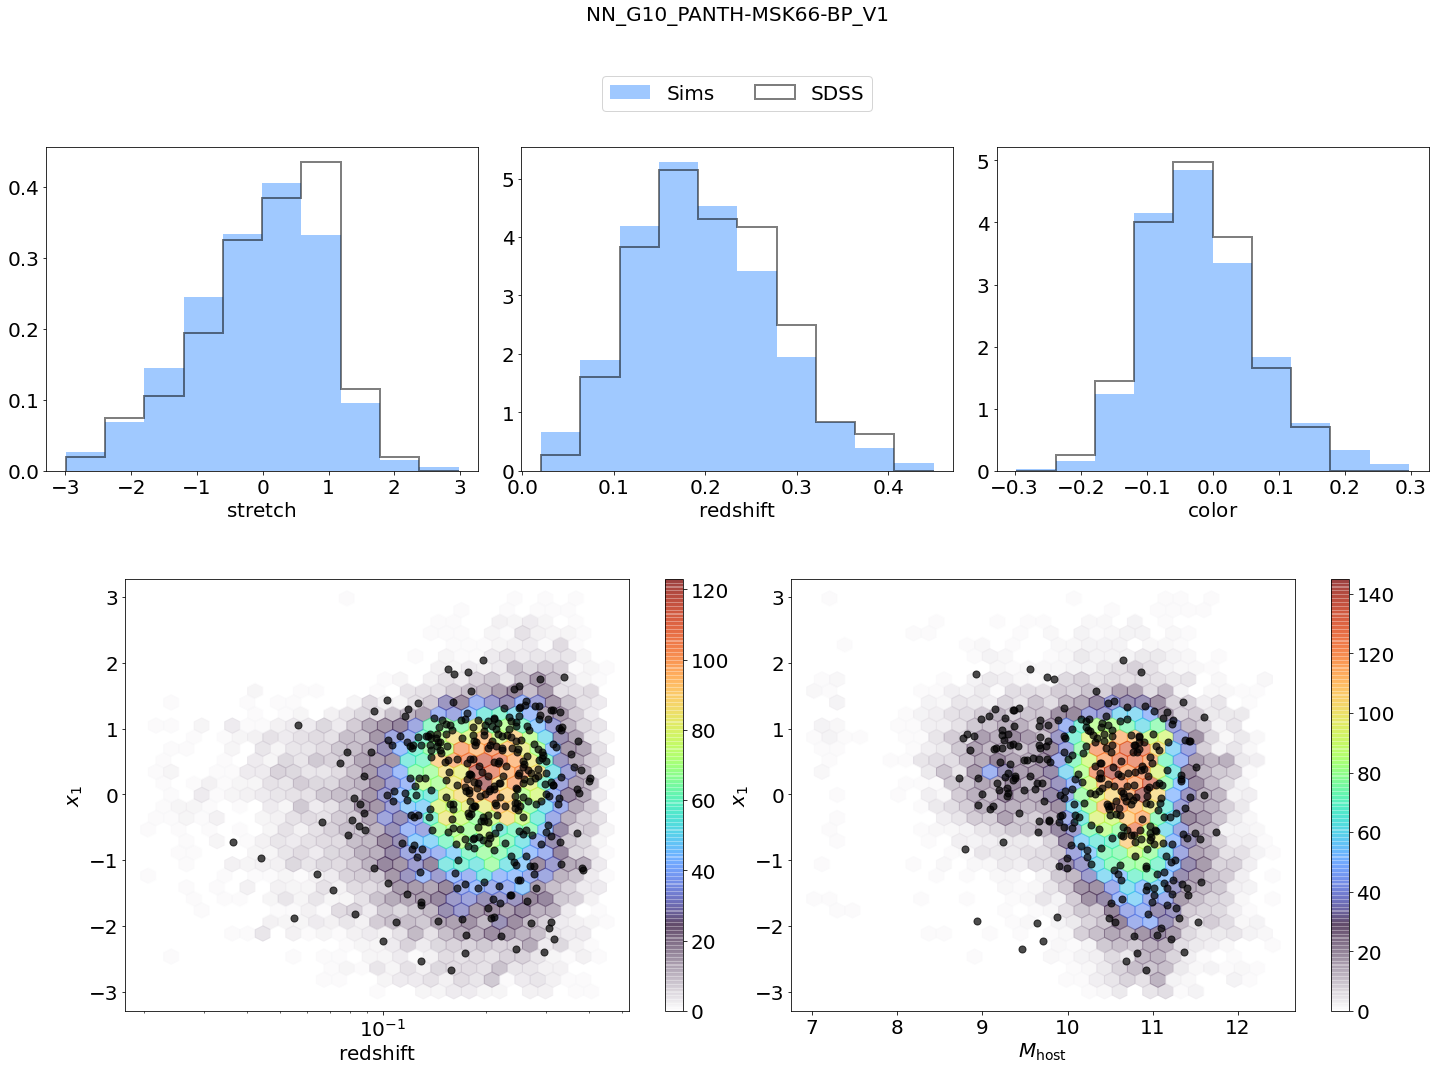

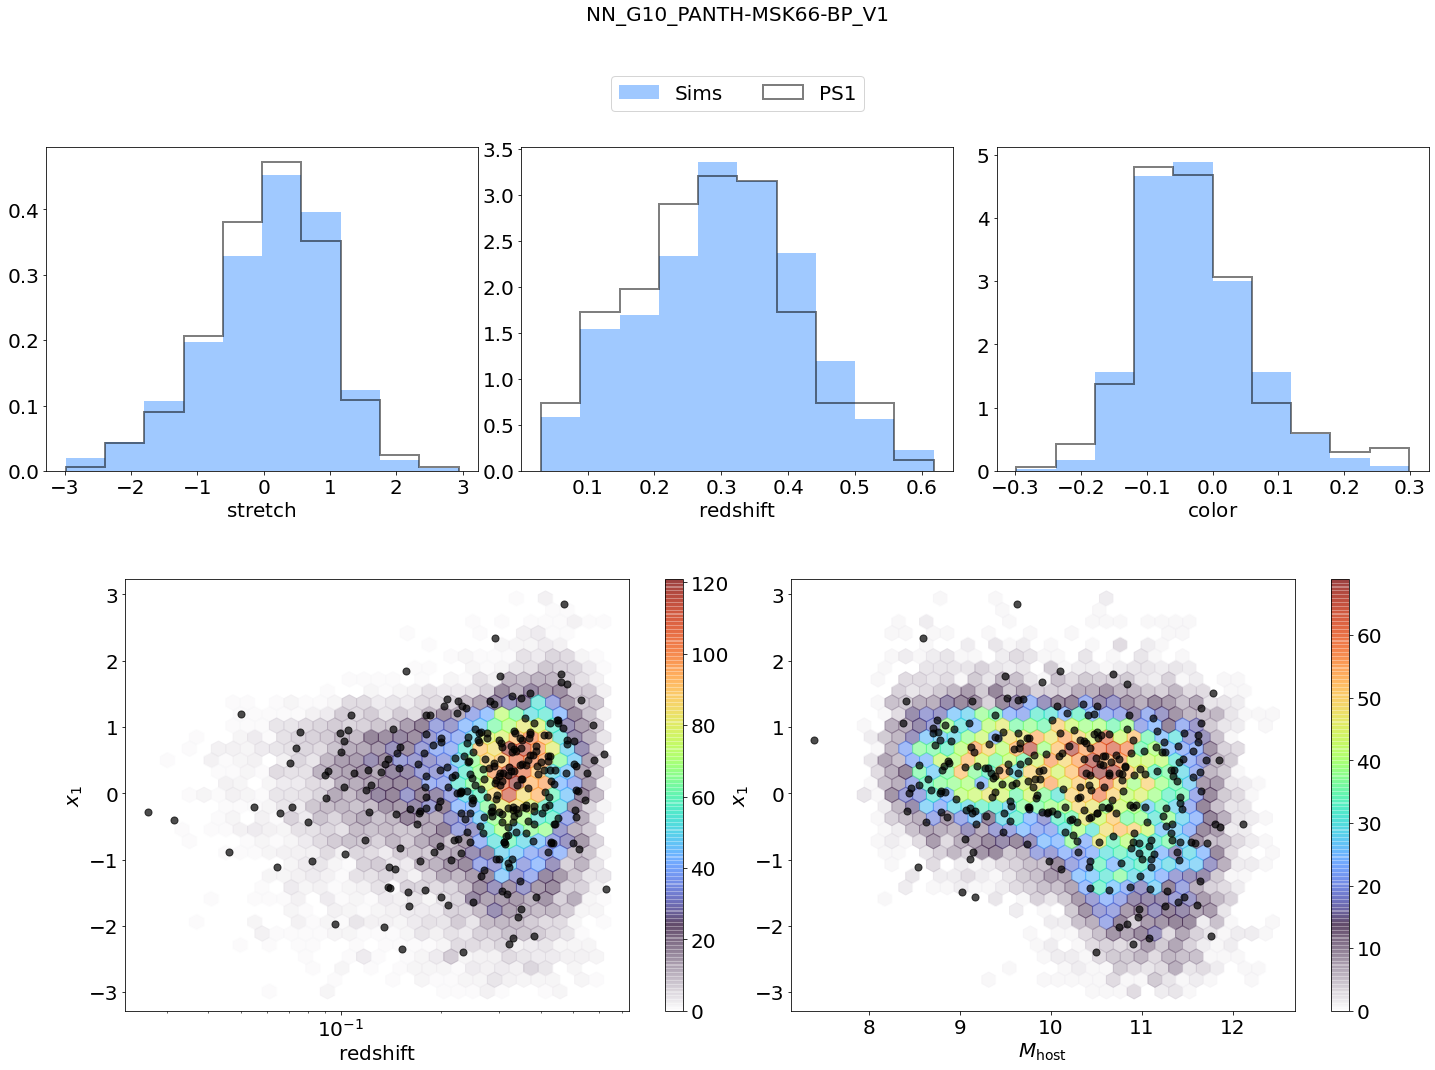

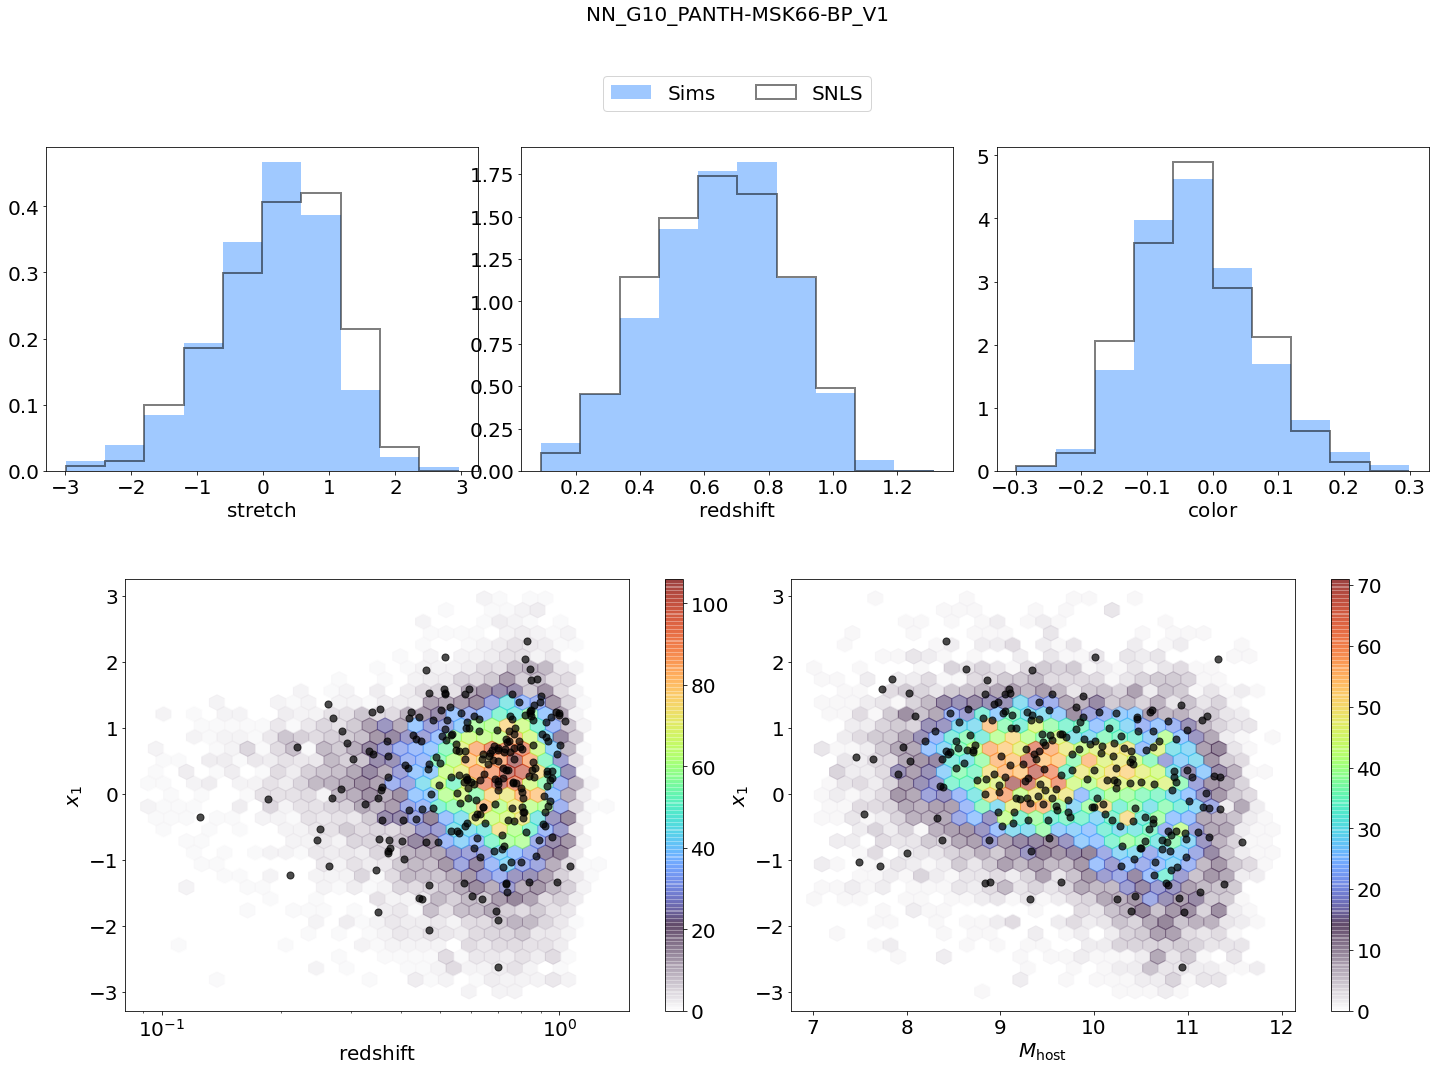

In [7]:
width_plot_cb = 0.35
space_cb = 0.025
width_cb = 0.0125
xmin_bottom = 0.075
ymin_bottom = 0.05
height_plot_cb = 0.40

xmin_top = 0.02
ymin_top = 0.15 + height_plot_cb
width_plot = 0.30
space_plot = 0.03
height_plot = 0.30

for i, zipped in enumerate(zip(surveys[1:-1], [1, 15, 4])):
    survey = zipped[0]
    idsurvey = zipped[-1]
    fig = plt.figure(figsize=[20, 15])
    
    ax4 = fig.add_axes([xmin_top, ymin_top,
                        width_plot, height_plot])
    
    ax1 = fig.add_axes([ax4.get_position().get_points()[1][0]
                        + space_plot, ymin_top,
                        width_plot, height_plot])
    
    ax5 = fig.add_axes([ax1.get_position().get_points()[1][0]
                        + space_plot, ymin_top,
                        width_plot, height_plot])
    
    ax2 = fig.add_axes([xmin_bottom, ymin_bottom,
                        width_plot_cb, height_plot_cb])
    axb = fig.add_axes([ax2.get_position().get_points()[1][0]
                        + space_cb, ymin_bottom,
                        width_cb, height_plot_cb])
    
    ax3 = fig.add_axes([axb.get_position().get_points()[1][0]
                        + 3*space_cb, ymin_bottom,
                        width_plot_cb, height_plot_cb])
    axc = fig.add_axes([ax3.get_position().get_points()[1][0]
                        + space_cb, ymin_bottom,
                        width_cb, height_plot_cb])
    
    df_full_data_used = df_full[df_full['survey'] == survey]
    fitprop_data_used = fitprop_data[fitprop_data['IDSURVEY'] == idsurvey]
    
    color_data = 'k'
    
    #############################################################################
    
    prophist = dict(alpha=.5, density=True)
    
    _, bins, _ = ax1.hist(fitprop_data_used.zCMB,
                          histtype='stepfilled',
                          facecolor=tools.cmap_tpw(0.35),
                          edgecolor=None,
                          label='Sims',
                          **prophist)
    
    ax1.hist(df_full_data_used.redshifts,
             bins=bins,
             histtype='step', lw=2,
             color=color_data,
             label=survey,
             **prophist)
    
    _, bins, _ = ax4.hist(fitprop_data_used.x1,
                          histtype='stepfilled',
                          facecolor=tools.cmap_tpw(0.35),
                          edgecolor=None,
                          label='Sims',
                          **prophist)
    
    ax4.hist(df_full_data_used.stretchs,
             bins=bins,
             histtype='step', lw=2,
             color=color_data,
             label=survey,
             **prophist)
    
    
    _, bins, _ = ax5.hist(fitprop_data_used.c,
                          histtype='stepfilled',
                          facecolor=tools.cmap_tpw(0.35),
                          edgecolor=None,
                          label='Sims',
                          **prophist)
    
    ax5.hist(df_full_data_used.colors,
             bins=bins,
             histtype='step', lw=2,
             color=color_data,
             label=survey,
             **prophist)
    
    #############################################################################
    
    prop2d = dict(alpha=.5, gridsize=30, cmap=tools.cmap_tpw)
    
    
    hb2 = ax2.hexbin(fitprop_data_used.zCMB,
                     fitprop_data_used.x1,
                     xscale='log',
                     **prop2d)
    ax2.set_xscale('log')
    
    cb2 = fig.colorbar(hb2, cax=axb)
    
    prop = dict(marker="o", s=50, lw=1, alpha=.7, color=color_data)
    
    ax2.scatter(df_full_data_used.redshifts,
                df_full_data_used.stretchs,
                label=survey, **prop)
    
    #############################################################################
    
    fitprop_data_used_mass7 = fitprop_data_used[fitprop_data_used['HOST_LOGMASS'] > 7]
    df_full_data_used_mass7 = df_full_data_used[df_full_data_used['hostmass'] > 7]
    
    hb3 = ax3.hexbin(fitprop_data_used_mass7.HOST_LOGMASS,
                     fitprop_data_used_mass7.x1,
                     **prop2d)
    
    cb3 = fig.colorbar(hb3, cax=axc)
    
    ax3.scatter(df_full_data_used_mass7.hostmass,
                df_full_data_used_mass7.stretchs,
                label=survey, **prop)
    #############################################################################
    
    ax1.tick_params(labelsize=20)
    ax4.tick_params(labelsize=20)
    ax5.tick_params(labelsize=20)
    ax2.tick_params(labelsize=20)
    cb2.ax.tick_params(labelsize=20)
    ax3.tick_params(labelsize=20)
    cb3.ax.tick_params(labelsize=20)
    
    ax1.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
    #ax1.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)
    
    ax4.set_xlabel(r"$\mathrm{stretch}$ ", fontsize=20)
    #ax4.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)
    
    ax5.set_xlabel(r"$\mathrm{color}$ ", fontsize=20)
    #ax5.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)
    
    ax2.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
    ax2.set_ylabel(r"$x_1$", fontsize=20)
    #cb2.set_label('counts', fontsize=20)
    
    ax3.set_xlabel(r"$M_\mathrm{host}$ ", fontsize=20)
    ax3.set_ylabel(r"$x_1$", fontsize=20)
    #cb3.set_label('counts', fontsize=20)
    
    ax1.legend(fontsize=20, ncol=2,
               loc='upper center',
               bbox_to_anchor=(0.5, 1.0, 0.0, 0.25))
    
    fig.suptitle(sc.value.split('/')[-1], fontsize=20)
    
    #fig.savefig('../../../Images/pdf/fitprop_data_' + sc.value.split('/')[-1]
    #            + '_' + survey + '.pdf',
    #            bbox_inches='tight')
    #fig.savefig('../../../Images/png/fitprop_data_' + sc.value.split('/')[-1]
    #            + '_' + survey + '.png',
    #            bbox_inches='tight', transparent=False)

## `age` module testing

In [3]:
pdmodel = age.PrompDelayModel()
pdmodel.draw_sample(z=0.04, size=1000)

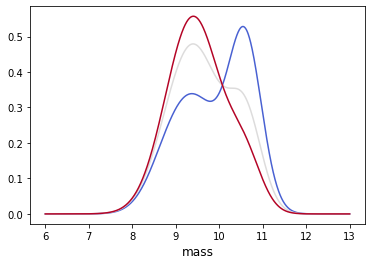

In [4]:
fig = pdmodel.show_pdf("mass", z=[0.05, 0.5, 1], zmax=1)

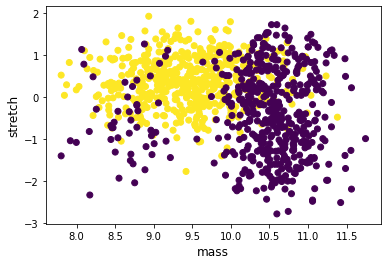

In [5]:
fig = pdmodel.show_scatter("mass","stretch", colorkey="age")

## Fit mass Brodie

In [6]:
with open('../../../Data/sne/lowz_df', 'rb') as f:
    lowz_df = pickle.load(f)

In [50]:
lowz_df['hg_masserr_nr'] = np.sqrt((lowz_df['hg_masserr_nr_down']**2
                                    + lowz_df['hg_masserr_nr_up']**2)/2)

In [51]:
lowz_df_fit = lowz_df.copy()
lowz_df_fit

In [46]:
lowz_df_fit.rename(columns={'zcmb': 'redshifts',
                            'hg_mass_nr': 'hostmass';
                            'hg_masserr_nr': 'hostmass_err'})

,CID,ra,dec,zcmb,hg_mass_sco,hg_masserr_sco,hg_mass_nr,hg_masserr_nr_down,hg_masserr_nr_up
0,2001ah,167.624,55.1608,0.05891,11.141,0.02,11.733746,0.100610,0.102540
1,2001az,248.614,76.0295,0.04059,11.376,0.059,11.563016,0.098809,0.099862
2,2001da,358.386,8.11728,0.01647,11.006,0.042,11.246402,0.100754,0.099997
3,2001en,21.3452,34.025,0.01544,11.133,0.078,11.390831,0.098434,0.100087
4,2001fe,144.488,25.4947,0.01449,10.277,0.095,11.013707,0.100463,0.099176
...,...,...,...,...,...,...,...,...,...
165,2000B,106.417,50.5888,0.02045,11.44,2.78,12.175438,0.098304,0.098759
166,2000cf,238.248,65.9378,0.03646,10.1732,0.2809,10.743448,0.098631,0.099377
167,2000cn,269.425,27.8257,0.02321,10.9619,0.2809,11.172982,0.100555,0.099259
168,2000dk,16.8446,32.4111,0.01602,10.4766,0.3742,12.195576,0.099497,0.099416


In [64]:
base_model = massevol.Evol3G3M3S(df)
base_model.minimize(limit_a=(0,1))
print(base_model.param)

{'mu_1': 9.42435033203514, 'sigma_1': 0.6352164641545026, 'a': 0.902710356796472, 'mu_2': 10.59321817727873, 'sigma_2': 0.3739487056160915, 'mu_3': 8.74496390066, 'sigma_3': 0.42788950723936164}


In [63]:
with open('../../../Data/mass/snf_mass', 'rb') as f:
    snf_mass = pickle.load(f)

### Plot mass histograms

#### Sco vs Taylor

No handles with labels found to put in legend.
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log


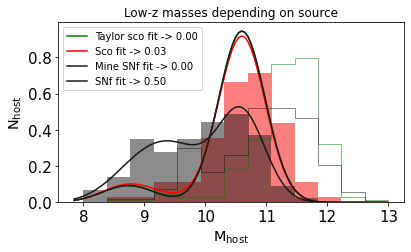

In [67]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

prop_hist = dict(bins=13, range=[8, 13], alpha=.5, density=True)

lowz_df_nr_sup8 = lowz_df[lowz_df['hg_mass_nr'] > 8]
ax.hist(lowz_df_nr_sup8['hg_mass_nr'],
        histtype='step',
        color='g',
        **prop_hist)

lowz_df_sco_sup8 = lowz_df[lowz_df['hg_mass_sco'] > 8]
ax.hist(lowz_df_sco_sup8['hg_mass_sco'],
        color=colors['low-z'],
        **prop_hist)

ax.hist(snf_mass[:, 0],
        color=colors['SNF'],
        **prop_hist,
        histtype='step')

ax.hist(df['hostmass'],
        color=colors['SNF'],
        **prop_hist)

ax.tick_params(labelsize=15)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{host}$", fontsize="x-large")

ax.legend(loc='upper left')

plt.title('Low-z masses depending on source')

def pdf_mass(x, fprompt):
    prompt_pdf = scipy.stats.norm.pdf(x,
                                      loc=9.41,
                                      scale=0.62)

    delay_pdf1 = scipy.stats.norm.pdf(x,
                                      loc=10.60,
                                      scale=0.38)

    delay_pdf2 = scipy.stats.norm.pdf(x,
                                      loc=8.74,
                                      scale=0.43)

    return(fprompt * prompt_pdf +
           (1-fprompt) * (0.90*delay_pdf1 + (1-0.90)*delay_pdf2))

def loglikepdf_mass_nr(fprompt):
    return -2*np.sum(np.log(pdf_mass(lowz_df_nr_sup8['hg_mass_nr'], fprompt)))

hg_sco_nparray = [lowz_df_sco_sup8['hg_mass_sco'].values[i]
                  for i in range(len(lowz_df_sco_sup8))]
def loglikepdf_mass_sco(fprompt):
    return -2*np.sum(np.log(pdf_mass(hg_sco_nparray, fprompt)))

def loglikepdf_mass_snf_mine(fprompt):
    return -2*np.sum(np.log(pdf_mass(snf_mass[:, 0], fprompt)))

def loglikepdf_mass_snf(fprompt):
    return -2*np.sum(np.log(pdf_mass(df['hostmass'], fprompt)))

def minimize_pdf_mass_nr(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_nr,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

def minimize_pdf_mass_sco(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_sco,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

def minimize_pdf_mass_snf_mine(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_snf_mine,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

def minimize_pdf_mass_snf(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_snf,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_mass_nr = minimize_pdf_mass_nr().values['fprompt']
bestfit_mass_sco = minimize_pdf_mass_sco().values['fprompt']
bestfit_mass_snf_mine = minimize_pdf_mass_snf_mine().values['fprompt']
bestfit_mass_snf = minimize_pdf_mass_snf().values['fprompt']

xlin = np.linspace(7.85, 12.98, 100)
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_nr),
        color='g',
        label=f'Taylor sco fit -> {bestfit_mass_nr:.2f}')
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_sco),
        color=colors['low-z'],
        label=f'Sco fit -> {bestfit_mass_sco:.2f}')
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_snf_mine),
        color=colors['SNF'],
        label=f'Mine SNf fit -> {bestfit_mass_snf_mine:.2f}')
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_snf),
        color=colors['SNF'],
        label=f'SNf fit -> {bestfit_mass_snf:.2f}')

ax.legend(loc='upper left')

#ax.plot(x, x, '--', linewidth=5, color='firebrick')
fig.savefig('../../../Images/pdf/mass_hists-fitted.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/mass_hists-fitted.png', bbox_inches='tight', dpi=600)

### Use SED fitted SNf data

In [30]:
sedsnf = pd.read_csv('../../../Data/mass/SNFactory_SEDfit_Masses.txt')
sedsnf = sedsnf.loc[sedsnf['name'].str.contains( 'SNF|LSQ|PTF', na=False, regex=True)]
sedsnf = sedsnf.rename(columns={'mass': 'hostmass', 'z': 'redshifts'})
sedsnf['hostmass_err'] = np.sqrt((sedsnf['mass_uppererr'].values**2 +
                                  sedsnf['mass_lowerr'].values**2)/2)
sedsnf_df = df_nc[df_nc['survey'] == 'SNF']
sedsnf_df['hostmass'] = sedsnf['hostmass'].values
sedsnf_df['hostmass_err'] = sedsnf['hostmass_err'].values
sedsnf_df_nonan = sedsnf_df[~np.isnan(sedsnf_df['hostmass'])]

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### lowz vs SNF_sed

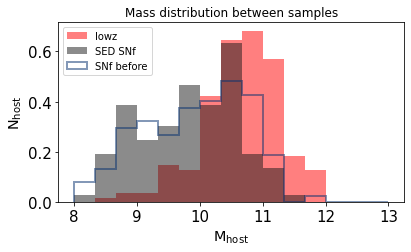

In [37]:
fig = plt.figure(figsize=[8, 5], facecolor='w')
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

prop_hist = dict(bins=15, range=[8, 13], alpha=.5, density=True)

# Actual lowz df
lowz_df = df_nc[df_nc['survey'] == 'low-z']
lowz_df_sco_sup8 = lowz_df[lowz_df['hostmass'] > 8]
ax.hist(lowz_df['hostmass'],
        color=colors['low-z'],
        label='lowz',
        **prop_hist)

# SED-fitted SNf masses
ax.hist(sedsnf_df_nonan['hostmass'],
        color=colors['SNF'],
        label='SED SNf',
        **prop_hist)

# # SED-fitted SNf masses + shift
# shift = 0.5
# ax.hist(sedsnf_df_nonan['hostmass']+shift,
#         color=colors['SNF'],
#         label=f'SED SNf+{shift}',
#         histtype='step',
#         lw=2,
#         **prop_hist)

# Previous SNf masses
ax.hist(df_nc[df_nc['survey'] == 'SNF']['hostmass'],
        color=colors['SDSS'],
        label='SNf before',
        histtype='step',
        lw=2,
        **prop_hist)

ax.tick_params(labelsize=15)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{host}$", fontsize="x-large")

ax.legend(loc='upper left')

plt.title('Mass distribution between samples')

fig.savefig('../../../Images/pdf/lowz_sedsnfnonan_comp-hist.pdf',
            bbox_inches='tight')
fig.savefig('../../../Images/png/lowz_sedsnfnonan_comp-hist.png',
            bbox_inches='tight', dpi=600)

#### Samples vs SNF_sed

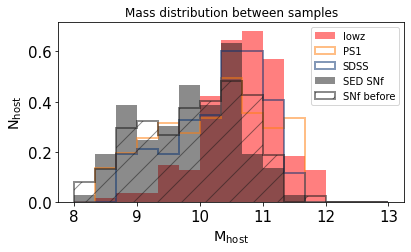

In [55]:
fig = plt.figure(figsize=[8, 5], facecolor='w')
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

prop_hist = dict(bins=15, range=[8, 13], alpha=.5, density=True)

# Actual lowz df
ax.hist(df_nc[df_nc['survey'] == 'low-z']['hostmass'],
        color=colors['low-z'],
        label='lowz',# hatch='/',
        **prop_hist)

# Actual PS1 df
ax.hist(df_nc[df_nc['survey'] == 'PS1']['hostmass'],
        color='C1',
        label='PS1',# hatch='-',
        histtype='step', lw=2,
        **prop_hist)

# Actual SDSS df
ax.hist(df_nc[df_nc['survey'] == 'SDSS']['hostmass'],
        color=colors['SDSS'],
        label='SDSS',# hatch='\\',
        histtype='step', lw=2,
        **prop_hist)

# SED-fitted SNf masses
ax.hist(sedsnf_df_nonan['hostmass'],
        color=colors['SNF'],
        label='SED SNf',# hatch='|',
        **prop_hist)

# Previous SNf masses
ax.hist(df_nc[df_nc['survey'] == 'SNF']['hostmass'],
        color=colors['SNF'],
        label='SNf before', hatch='/',
        histtype='step', lw=2,
        **prop_hist)

# # SED-fitted SNf masses + shift
# shift = 0.5
# ax.hist(sedsnf_df_nonan['hostmass']+shift,
#         color=colors['SNF'],
#         label=f'SED SNf+{shift}',
#         histtype='step',
#         lw=2,
#         **prop_hist)

ax.tick_params(labelsize=15)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{host}$", fontsize="x-large")

ax.legend(loc='upper right')

plt.title('Mass distribution between samples')

fig.savefig('../../../Images/pdf/samples_sedsnfnonan_comp-hist.pdf',
            bbox_inches='tight')
fig.savefig('../../../Images/png/samples_sedsnfnonan_comp-hist.png',
            bbox_inches='tight', dpi=600)

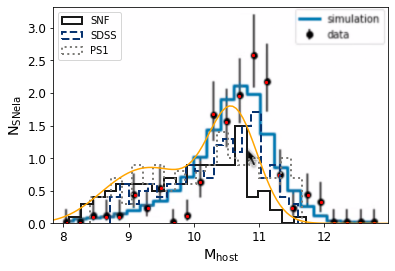

In [70]:
img = plt.imread("../../../Images/png/mass_hist_lowz_crop_zero.png")
fig, ax = plt.subplots()

Mmin = 7.85
Mmax = 12.98
Cmin = 0
Cmax = 170
f = 85.185

Mlist = [8.05, 8.25, 8.45, 8.65, 8.85,
         9.1, 9.3, 9.5, 9.7, 9.9,
         10.1, 10.3, 10.5, 10.7, 10.9,
         11.1, 11.3, 11.5, 11.75, 11.95,
         12.15, 12.35, 12.55, 12.76]

ax.scatter(Mlist,
           np.asarray([0, 0, 8, 8, 8,
                       37, 20, 46, 0, 10,
                       54, 143, 132, 166, 220,
                       185, 63, 20, 37, 28,
                       1, 0, 0, 0])/f,
          color='red', s=5)
ax.imshow(img, extent=[Mmin, Mmax, 0, 3.32])
          #[7.81, 12.94, 0, 170])

#ax.set_xlim([7.81, 12.94])
#ax.set_ylim([0, 170])

ax.tick_params(labelsize=12)

ax.set_xlabel(r'$\mathrm{M}_\mathrm{host}$', fontsize = 'x-large')
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

def pdf_mass(x, fprompt):
    prompt_pdf = scipy.stats.norm.pdf(x,
                                      loc=9.41,
                                      scale=0.62)

    delay_pdf1 = scipy.stats.norm.pdf(x,
                                      loc=10.60,
                                      scale=0.38)

    delay_pdf2 = scipy.stats.norm.pdf(x,
                                      loc=8.74,
                                      scale=0.43)

    return(fprompt * prompt_pdf +
           (1-fprompt) * (0.90*delay_pdf1 + (1-0.90)*delay_pdf2))

def loglikepdf_mass(fprompt):
    return -2*np.sum(np.log(pdf_mass(Mlist, fprompt)))

def minimize_pdf_mass(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass,
                      print_level=print_level,
                      pedantic=False,
                      fprompt=0.1,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_mass = minimize_pdf_mass().values

xlin = np.linspace(7.85, 12.98, 100)
ax.plot(xlin,
        3*pdf_mass(xlin, bestfit_mass['fprompt']),
        color='orange')

ls = ['-', '--', ':']

for i, survey in enumerate(surveys[:3]):
    df_ncused = df_nc[df_nc['survey'] == survey]
    where = df_ncused['hostmass'] > 8
    df_cused = df_c[df_c['survey'] == survey]

    ax.hist(df_ncused[where].hostmass, bins=20,
            weights=[0.100 for i in range(len(df_ncused[where].hostmass))],
            histtype='step', lw=2, fill=False,
            zorder=1,
            edgecolor=colors[survey],
            facecolor=alphacolors(.5, survey),
            ls=ls[i], label=survey)
    
ax.legend(loc='upper left')

#ax.plot(x, x, '--', linewidth=5, color='firebrick')
#fig.savefig('../../../Images/png/mass_hist_lowz-fitted.png', bbox_inches='tight', dpi=600)

In [112]:
bestfit_mass['fprompt']

0.41157248447333517